Notebook nueva para reentrenar a partir de pesos desde COCO dataset. Se une el dataset de rotondas y de UAVDT. Se mezclan por separado el de train y el de val.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Installing dependencies**

In [2]:
!git clone https://github.com/ZQPei/deep_sort_pytorch.git
%cd deep_sort_pytorch

Cloning into 'deep_sort_pytorch'...
remote: Enumerating objects: 1078, done.
remote: Counting objects: 100% (352/352), done.
remote: Compressing objects: 100% (258/258), done.
remote: Total 1078 (delta 155), reused 261 (delta 90), pack-reused 726 (from 1)
Receiving objects: 100% (1078/1078), 29.15 MiB | 16.56 MiB/s, done.
Resolving deltas: 100% (506/506), done.
/content/deep_sort_pytorch


In [3]:
!pip install supervision
!pip install -U sahi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 32.1 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=15489110d01b42021d164a0d5101df9bfa951b2d9a28a744cd828ae382bd1664
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.10.0.84
    Uninstalling opencv-python-4.10.0.84:
      Successfully uninstalled opencv-python-4.10.0.84


In [4]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version


Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.5 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0)
ERROR: No matching distribution found for torch==1.5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 14.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-9p5vpqr7

In [5]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install git+https://github.com/facebookresearch/fvcore.git
!pip install git+https://github.com/facebookresearch/detectron2.git

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-hs31t3w5
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-hs31t3w5
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-kjqn4w9b
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-kjqn4w9b
  Resolved https://github.com/facebookresearch/fvcore.git to commit d051804c97dfd7c8f349996fefd8644fe2955bc2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.6-py3-none-any.whl size=65605 sha256=85239749837ea1d33f95be863fd3de9cd59c9fade3817e65ec88e4f97f5b1837
  Sto

### **Importing libraries**

In [2]:
# Miscellaneous
import os
import json
import shutil
import random
from tqdm import tqdm
from PIL import Image
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
import supervision as sv
from IPython.display import display, clear_output, Image
import numpy as np
import time
from psutil import virtual_memory
import multiprocessing
from scipy.interpolate import splprep, splev
import sklearn
import math
from typing import Tuple, List, Optional
from shapely.geometry import Point, Polygon

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# DeepSORT
%cd deep_sort_pytorch
!gdown 1_qwTWdzT9dWNudpusgKavj_4elGgbkUN -O deep_sort/deep/checkpoint/ckpt.t7 # Download ckpt.t7 directly into the checkpoint directory
from deep_sort import DeepSort
#https://drive.google.com/file/d/1_qwTWdzT9dWNudpusgKavj_4elGgbkUN/view?usp=drive_link

# detectron
import detectron2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.logger import setup_logger
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer, hooks, DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.evaluation import COCOEvaluator


# SAHI
from sahi.predict import get_sliced_prediction, predict, get_prediction, get_sliced_prediction
from sahi.utils.cv import read_image
from sahi.models.base import DetectionModel
from sahi.models.detectron2 import Detectron2DetectionModel
from sahi.prediction import ObjectPrediction
from sahi.utils.cv import get_bbox_from_bool_mask, get_coco_segmentation_from_bool_mask
from sahi.utils.import_utils import check_requirements

import torch
from typing import List, Optional
import logging

logger = logging.getLogger(__name__)

/content/deep_sort_pytorch
Downloading...
From: https://drive.google.com/uc?id=1_qwTWdzT9dWNudpusgKavj_4elGgbkUN
To: /content/deep_sort_pytorch/deep_sort/deep/checkpoint/ckpt.t7
100% 46.0M/46.0M [00:01<00:00, 41.3MB/s]


### **Download, unzip and merge datasets**

In [ ]:
# UAVDT dataset
!gdown "1QbS_Jd3_vAvPlnmFxkR4Tv3J-Cqmnns1"
!unzip /content/uavdt.zip -d /content/uavdt_dataset/
os.remove('/content/uavdt.zip')

Streaming output truncated to the last 5000 lines.
  inflating: /content/uavdt_dataset/UAVDT-DET/val/labels/M0207_img000835.txt  
  inflating: /content/uavdt_dataset/UAVDT-DET/val/labels/M0207_img000846.txt  
  inflating: /content/uavdt_dataset/UAVDT-DET/val/labels/M0207_img000848.txt  
  inflating: /content/uavdt_dataset/UAVDT-DET/val/labels/M0207_img000858.txt  
  inflating: /content/uavdt_dataset/UAVDT-DET/val/labels/M0207_img000872.txt  
  inflating: /content/uavdt_dataset/UAVDT-DET/val/labels/M0207_img000873.txt  
  inflating: /content/uavdt_dataset/UAVDT-DET/val/labels/M0207_img000885.txt  
  inflating: /content/uavdt_dataset/UAVDT-DET/val/labels/M0208_img000007.txt  
  inflating: /content/uavdt_dataset/UAVDT-DET/val/labels/M0208_img000010.txt  
  inflating: /content/uavdt_dataset/UAVDT-DET/val/labels/M0208_img000012.txt  
  inflating: /content/uavdt_dataset/UAVDT-DET/val/labels/M0208_img000017.txt  
  inflating: /content/uavdt_dataset/UAVDT-DET/val/labels/M0208_img000020.txt  
 

In [ ]:
# roundabout dataset
os.makedirs('/content/roundabout_dataset', exist_ok=True)

!gdown "1Qw5uTlfCvOlWhi0N_ByBHC8Qrs4d2Cf7" # train.zip
!unzip /content/train.zip -d /content/roundabout_dataset/train/
os.remove('/content/train.zip')

!gdown "1QwNRa0urRLdYgDdSagw4c56UIUMHcJPw" # val.zip
!unzip /content/val.zip -d /content/roundabout_dataset/val/
os.remove('/content/val.zip')

Streaming output truncated to the last 5000 lines.
  inflating: /content/roundabout_dataset/train/train/00053_frame000999_original.jpg  
  inflating: /content/roundabout_dataset/train/train/00053_frame001000_original.jpg  
  inflating: /content/roundabout_dataset/train/train/00053_frame001001_original.jpg  
  inflating: /content/roundabout_dataset/train/train/00053_frame001002_original.jpg  
  inflating: /content/roundabout_dataset/train/train/00053_frame001005_original.jpg  
  inflating: /content/roundabout_dataset/train/train/00053_frame001006_original.jpg  
  inflating: /content/roundabout_dataset/train/train/00053_frame001007_original.jpg  
  inflating: /content/roundabout_dataset/train/train/00053_frame001008_original.jpg  
  inflating: /content/roundabout_dataset/train/train/00053_frame001009_original.jpg  
  inflating: /content/roundabout_dataset/train/train/00053_frame001010_original.jpg  
  inflating: /content/roundabout_dataset/train/train/00053_frame001011_original.jpg  
  i

In [ ]:
import shutil
import os
from tqdm import tqdm

# Create a directory for the combined dataset
combined_dir_train = '/content/combined_dataset/train'
combined_dir_val = '/content/combined_dataset/val'
os.makedirs(combined_dir_train, exist_ok=True)
os.makedirs(combined_dir_val, exist_ok=True)

# Move images from UAVDT dataset
uavdt_images_train_dir = '/content/uavdt_dataset/UAVDT-DET/train/images'
uavdt_images_val_dir = '/content/uavdt_dataset/UAVDT-DET/val/images'

for filename in tqdm(os.listdir(uavdt_images_train_dir)):
    shutil.move(os.path.join(uavdt_images_train_dir, filename), combined_dir_train)

for filename in tqdm(os.listdir(uavdt_images_val_dir)):
    shutil.move(os.path.join(uavdt_images_val_dir, filename), combined_dir_val)

# Move images from roundabout dataset
roundabout_images_train_dir = '/content/roundabout_dataset/train/train'
roundabout_images_val_dir = '/content/roundabout_dataset/val/val'

for filename in tqdm(os.listdir(roundabout_images_train_dir)):
    shutil.move(os.path.join(roundabout_images_train_dir, filename), combined_dir_train)

for filename in tqdm(os.listdir(roundabout_images_val_dir)):
    shutil.move(os.path.join(roundabout_images_val_dir, filename), combined_dir_val)

100%|██████████| 3096/3096 [00:00<00:00, 28556.15it/s]


In [ ]:
# Download annotations
!gdown "1QyOSauGpbXgPm1ltXdUjUUnD-rkRw1xG" # train set annotations
!gdown "1R19J8Ics0v1tGOApHUnlP9acMF6GDk0G" # val set annotations

Downloading...
From (original): https://drive.google.com/uc?id=1QyOSauGpbXgPm1ltXdUjUUnD-rkRw1xG
From (redirected): https://drive.google.com/uc?id=1QyOSauGpbXgPm1ltXdUjUUnD-rkRw1xG&confirm=t&uuid=f0093bb3-9a61-4891-b740-60fe6b7ae738
To: /content/annotations_coco_train_RBT-UAVDT.json
100% 302M/302M [00:03<00:00, 90.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1R19J8Ics0v1tGOApHUnlP9acMF6GDk0G
To: /content/annotations_coco_val_RBT-UAVDT.json
100% 54.1M/54.1M [00:00<00:00, 91.8MB/s]


### **Training on merged dataset**

#### **Resources**

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jul 17 15:29:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              45W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# Obtener el número de núcleos de CPU disponibles
num_cores = multiprocessing.cpu_count()
num_cores

12

#### **Registering Datasets**

In [ ]:
setup_logger()  # Inicializa el logger de detectron2 para registrar eventos y mensajes importantes durante la ejecución.

# Register your dataset if not already done
DatasetCatalog.clear()  # Clear previously registered datasets
MetadataCatalog.clear()

# Register the COCO datasets
register_coco_instances("aerial_train", {}, "/content/annotations_coco_train_RBT-UAVDT.json", "/content/combined_dataset/train")
register_coco_instances("aerial_val", {}, "/content/annotations_coco_val_RBT-UAVDT.json", "/content/combined_dataset/val")

# Add category names
thing_classes = ['car']
MetadataCatalog.get("aerial_train").thing_classes = thing_classes
MetadataCatalog.get("aerial_val").thing_classes = thing_classes

#### **Configuration and training**

In [ ]:
batch_size = 12
epochs = 10
train_size = 35000+12380
print((train_size // batch_size) * epochs)
print((train_size // batch_size) * epochs*1/3)
print((train_size // batch_size) * epochs*2/3)


39480
13160.0
26320.0


In [ ]:
# Set up configuration
train_size = 35000+12380
batch_size = 12
epochs = 10
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("aerial_train",)
cfg.DATASETS.TEST = ("aerial_val",)
cfg.DATALOADER.NUM_WORKERS = 6
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Pretrained weights from COCO
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/Conteo de Maniobras/Models/FasterRCNN/re_train/Model_more_epochs/model_final.pth"
cfg.SOLVER.IMS_PER_BATCH = batch_size  # Batch size (images per batch)
cfg.SOLVER.BASE_LR = 0.001  # Learning rate
cfg.SOLVER.MAX_ITER = (train_size//batch_size) * epochs # Number of iterations
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Number of classes (1 class + background)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.OUTPUT_DIR = '/content/drive/MyDrive/Conteo de Maniobras/Models/FasterRCNN/re_train/Model_more_epochs'
cfg.TEST.EVAL_PERIOD = 5000  # Evaluate the model every 5000 iterations
cfg.SOLVER.CHECKPOINT_PERIOD = 2000  # Save checkpoints every 2000 iterations


# Freeze the backbone (ResNet) up to stage 2
cfg.MODEL.BACKBONE.FREEZE_AT = 2

cfg.SOLVER.WARMUP_ITERS = 4000
cfg.SOLVER.STEPS = (13000, 26000)
cfg.SOLVER.GAMMA = 0.1

# Create the output directory if it does not exist
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Custom trainer class to include validation hook
class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

# Initialize the trainer
trainer = CustomTrainer(cfg)

# Add validation loss hook
#trainer.register_hooks([hooks.EvalHook(cfg.TEST.EVAL_PERIOD, lambda: trainer.test(cfg, trainer.model))])

# Check if there is a checkpoint to resume from
last_checkpoint = os.path.join(cfg.OUTPUT_DIR, "last_checkpoint")
if os.path.exists(last_checkpoint):
    trainer.resume_or_load(resume=False)
else:
    trainer.resume_or_load(resume=False)

# Start or resume training
trainer.train()

# Save the final weights after training
final_weights_path = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
trainer.checkpointer.save("model_final")
print(f"Final weights saved at {final_weights_path}")

[08/09 17:14:40 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[08/09 17:15:30 d2.utils.events]:  eta: 2:26:13  iter: 30019  total_loss: 0.3028  loss_cls: 0.06185  loss_box_reg: 0.1894  loss_rpn_cls: 0.002699  loss_rpn_loc: 0.03949    time: 0.9704  last_time: 0.9141  data_time: 0.0679  last_data_time: 0.0328   lr: 1e-05  max_mem: 27964M
[08/09 17:15:52 d2.utils.events]:  eta: 2:25:45  iter: 30039  total_loss: 0.3019  loss_cls: 0.06265  loss_box_reg: 0.1947  loss_rpn_cls: 0.002491  loss_rpn_loc: 0.03851    time: 0.9662  last_time: 0.9397  data_time: 0.0526  last_data_time: 0.0446   lr: 1e-05  max_mem: 27964M
[08/09 17:16:12 d2.utils.events]:  eta: 2:25:52  iter: 30059  total_loss: 0.2974  loss_cls: 0.06505  loss_box_reg: 0.1902  loss_rpn_cls: 0.00145  loss_rpn_loc: 0.03755    time: 0.9678  last_time: 0.9290  data_time: 0.0482  last_data_time: 0.0440   lr: 1e-05  max_mem: 27964M
[08/09 17:16:31 d2.utils.events]:  eta: 2:25:34  iter: 30079  total_loss: 0.2661  loss_cls: 0.05472  loss_box_reg: 0.1797  loss_rpn_cls: 0.001365  loss_rpn_loc: 0.0318    ti

[08/09 18:37:04 d2.evaluation.evaluator]: Inference done 11/8830. Dataloading: 0.0015 s/iter. Inference: 0.0437 s/iter. Eval: 0.0003 s/iter. Total: 0.0455 s/iter. ETA=0:06:41
[08/09 18:37:09 d2.evaluation.evaluator]: Inference done 124/8830. Dataloading: 0.0017 s/iter. Inference: 0.0425 s/iter. Eval: 0.0003 s/iter. Total: 0.0446 s/iter. ETA=0:06:27
[08/09 18:37:14 d2.evaluation.evaluator]: Inference done 237/8830. Dataloading: 0.0017 s/iter. Inference: 0.0424 s/iter. Eval: 0.0003 s/iter. Total: 0.0445 s/iter. ETA=0:06:22
[08/09 18:37:19 d2.evaluation.evaluator]: Inference done 351/8830. Dataloading: 0.0017 s/iter. Inference: 0.0423 s/iter. Eval: 0.0003 s/iter. Total: 0.0444 s/iter. ETA=0:06:16
[08/09 18:37:24 d2.evaluation.evaluator]: Inference done 462/8830. Dataloading: 0.0018 s/iter. Inference: 0.0425 s/iter. Eval: 0.0003 s/iter. Total: 0.0446 s/iter. ETA=0:06:13
[08/09 18:37:29 d2.evaluation.evaluator]: Inference done 574/8830. Dataloading: 0.0018 s/iter. Inference: 0.0425 s/iter. 

[08/09 19:56:40 d2.evaluation.evaluator]: Inference done 11/8830. Dataloading: 0.0045 s/iter. Inference: 0.0437 s/iter. Eval: 0.0004 s/iter. Total: 0.0486 s/iter. ETA=0:07:08
[08/09 19:56:45 d2.evaluation.evaluator]: Inference done 123/8830. Dataloading: 0.0019 s/iter. Inference: 0.0428 s/iter. Eval: 0.0003 s/iter. Total: 0.0451 s/iter. ETA=0:06:33
[08/09 19:56:50 d2.evaluation.evaluator]: Inference done 232/8830. Dataloading: 0.0019 s/iter. Inference: 0.0433 s/iter. Eval: 0.0003 s/iter. Total: 0.0456 s/iter. ETA=0:06:32
[08/09 19:56:55 d2.evaluation.evaluator]: Inference done 344/8830. Dataloading: 0.0019 s/iter. Inference: 0.0431 s/iter. Eval: 0.0003 s/iter. Total: 0.0454 s/iter. ETA=0:06:24
[08/09 19:57:00 d2.evaluation.evaluator]: Inference done 456/8830. Dataloading: 0.0019 s/iter. Inference: 0.0430 s/iter. Eval: 0.0003 s/iter. Total: 0.0452 s/iter. ETA=0:06:18
[08/09 19:57:05 d2.evaluation.evaluator]: Inference done 568/8830. Dataloading: 0.0019 s/iter. Inference: 0.0430 s/iter. 

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir '/content/drive/MyDrive/Conteo de Maniobras/Models/FasterRCNN/re_train/Model_more_epochs'

### **Object Detection**

#### **Load model**

In [3]:
# Setup configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))

# Load weights
#cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/Conteo de Maniobras/Models/FasterRCNN/re_train/Model_more_epochs/model_final.pth" # cuenta CSI
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/CSI/model_final.pth" # cuenta personal
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9  # Set the threshold for this model
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Set the number of classes as per your training
#cfg.DATASETS.TEST = ("aerial_val", )  # Validation set is used for testing here
class_names = ['car'] # hard-coded so as not to load and register dataset each time
# Create predictor
predictor = DefaultPredictor(cfg)

#### **Subclass Detectron2DetectionMode for SAHI detection**

In [ ]:
class CustomDetectron2DetectionModel(Detectron2DetectionModel):
    def set_model(self, model, **kwargs):
        """
        Set the Detectron2 model.
        Args:
            model (Any): Loaded Detectron2 model, such as DefaultPredictor instance.
        """
        # Assign the loaded model to self.model
        self.model = model

        # Set confidence threshold if provided in kwargs
        if "confidence_threshold" in kwargs:
            self.confidence_threshold = kwargs["confidence_threshold"]

        # Set device (cpu or cuda) if provided in kwargs
        self.device = kwargs.get("device", "cuda" if torch.cuda.is_available() else "cpu")

        # Set category mapping if provided in kwargs
        if "category_mapping" in kwargs:
            self.category_mapping = kwargs["category_mapping"]
            # Initialize category names from category mapping
            self.category_names = list(self.category_mapping.values())

In [ ]:
# Wrap the Detectron2 model with SAHI's Detectron2DetectionModel
category_mapping = {'0': "car"} # hard coded so as not to load and register dataset each time

sahi_predictor = CustomDetectron2DetectionModel(
    model=predictor,
    confidence_threshold=cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST,
    device="cuda" if torch.cuda.is_available() else "cpu",
    category_mapping = category_mapping
)

sahi_predictor.set_model(predictor)

#### **Images**

In [ ]:
def predict_on_image(image_path, predictor, save_image=False):
    # Read the image
    img = cv2.imread(image_path) if type(image_path) == str else image_path

    # Make predictions
    outputs = predictor(img)

    # Visualize the results
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Display the image with predictions
    cv2_imshow(out.get_image()[:, :, ::-1])
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Save the output image if needed
    if save_image:
      output_image_path = image_path.replace(".jpg", "_predictions_UAVDT.jpg")
      cv2.imwrite(output_image_path, out.get_image()[:, :, ::-1])
      print(f"Predictions saved to {output_image_path}")


In [ ]:
folder = '/content/combined_dataset/val'
def predict_random_images(predictor, k=5):
  img_paths = random.choices(os.listdir(folder), k=k)
  for img_path in tqdm(img_paths):
    predict_on_image(image_path=os.path.join(folder, img_path), predictor=predictor, save_image=False)
    print ('\n')

predict_random_images(predictor)

In [ ]:
img_path = '/content/drive/MyDrive/CSI/val/00001_frame000417_original.jpg'

predict_on_image(image_path=img_path, predictor=predictor, save_image=False)

In [ ]:
img_path = '/content/drive/MyDrive/Conteo de Maniobras/Models/FasterRCNN/Test/P1849.jpg'

predict_on_image(image_path=img_path, predictor=predictor, save_image=True)

#### **Videos**

##### **Funciones auxiliares**

In [ ]:
def predict_on_video(video_path, output_video_path, predictor, line_thickness=3, font_scale=0.7):
    # Read the video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Define codec and create VideoWriter object
    #output_video_path = video_path.replace(video_path[-4:], "_predictions_UAVDT.mp4")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # Check if VideoWriter object was successfully created
    if not out.isOpened():
        print(f"Error: Could not open output video {output_video_path}")
        return

    # Process each frame with a progress bar
    for frame_index in tqdm(range(total_frames), desc="Processing video"):
        # Set the video position to the desired frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the frame to a format compatible with the model
        #img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        outputs = predictor(frame)["instances"].to("cpu")

        # Extract the bounding boxes, classes, and scores
        boxes = outputs.pred_boxes if outputs.has("pred_boxes") else None
        classes = outputs.pred_classes if outputs.has("pred_classes") else None
        scores = outputs.scores if outputs.has("scores") else None

        if boxes is not None:
            for i in range(len(boxes)):
                x1, y1, x2, y2 = map(int, boxes[i].tensor.numpy()[0])
                cls = int(classes[i])
                score = scores[i].item()

                # Draw the bounding box
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), thickness=line_thickness)

                # Prepare the label
                label = f'{MetadataCatalog.get(cfg.DATASETS.TEST[0]).thing_classes[cls]} {score:.2f}'
                (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, 1)
                cv2.rectangle(frame, (x1, y1 - h - 10), (x1 + w, y1), (0, 255, 0), -1)
                cv2.putText(frame, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness=1)

        # Write the processed frame to the output video
        out.write(frame)

    # Release everything if job is finished
    cap.release()
    out.release()
    cv2.destroyAllWindows()

    print(f"Predictions saved to {output_video_path}")


In [ ]:
def predict_on_frames(video_path, predictor, frame_indices, output_folder):
    '''Makes prediction on specified frames of the specified video, and outputs the
    images of the frames with it's bounding boxes
    '''
    # Read the video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for frame_index in tqdm(frame_indices, desc='Frames'):
        if frame_index >= frame_count:
            print(f"Frame index {frame_index} is out of range for this video.")
            continue

        # Set the video position to the desired frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
        ret, frame = cap.read()
        if not ret:
            print(f"Error: Could not read frame {frame_index}")
            continue

        # Make predictions
        outputs = predictor(frame)

        # Visualize the results
        metadata = {"thing_classes": ["car"]} # hard code it so as not to load dataset
        #v = Visualizer(frame[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
        v = Visualizer(frame[:, :, ::-1], metadata, scale=1.2)
        out_frame = v.draw_instance_predictions(outputs["instances"].to("cpu")).get_image()[:, :, ::-1]

        # Save the output image
        frame_output_path = output_folder+video_path.split('/')[-1].replace('.mp4', f'_prediction_frame_{frame_index}.jpg')
        cv2.imwrite(frame_output_path, out_frame)

    print(f"Prediction images for frames {frame_indices[0]} to {frame_indices[-1]} saved")

    # Release the video capture object
    cap.release()

In [ ]:
def get_number_of_frames(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return -1

    # Get the number of frames
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Release the video capture object
    cap.release()

    return frame_count


def get_fps(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return

    # Get the frames per second (fps)
    fps = cap.get(cv2.CAP_PROP_FPS)
    # Release the video capture object
    cap.release()

    return fps

In [ ]:
def create_video_from_frames(image_dir, output_video_path, fps=30):
  '''Creates a video from the images in image_dir'''

  # Get the list of image files in the directory
  img_list = [img for img in os.listdir(image_dir) if img.endswith(".jpg")]
  images = sorted(img_list, key=lambda x: int(x.split('_')[-1].split('.')[0]))  # Sort the images based on the frame number

  # Read the first image to get the dimensions
  frame = cv2.imread(os.path.join(image_dir, images[0]))
  height, width, layers = frame.shape
  video = cv2.VideoWriter(output_video_path, 0, fps, (width,height))

  for image in tqdm(images, desc='Images'):
      video.write(cv2.imread(os.path.join(image_dir, image)))

  cv2.destroyAllWindows()
  video.release()

##### **Predictions**

In [ ]:
# VIDEO CORTO DESDE ARRIBA
video_path = '/content/drive/MyDrive/Conteo de Maniobras/DJI_20240604174215_0006_V.mp4'
output_folder = '/content/drive/MyDrive/Conteo de Maniobras/Models/FasterRCNN/re_train/Test/'
output_video_path = output_folder+video_path.split('/')[-1].replace('.MP4', '_predictions_2.mp4')

predict_on_video(video_path=video_path, output_video_path=output_video_path, predictor=predictor)

Processing video:  99%|█████████▉| 320/322 [04:14<00:01,  1.26it/s]

Predictions saved to /content/drive/MyDrive/Conteo de Maniobras/Models/FasterRCNN/re_train/Test/DJI_20240604174215_0006_V.mp4


In [ ]:
# VIDEO LARGO DESDE ARRIBA
video_path = '/content/drive/MyDrive/Conteo de Maniobras/DJI_20240604175037_0009_V.mp4'
output_folder = '/content/drive/MyDrive/Conteo de Maniobras/Models/FasterRCNN/re_train/Test/'
output_video_path = output_folder+video_path.split('/')[-1].replace('.mp4', '_predictions.mp4')

predict_on_video(video_path=video_path, output_video_path=output_video_path, predictor=predictor)

Processing video: 100%|█████████▉| 6852/6854 [1:33:03<00:01,  1.23it/s]

Predictions saved to /content/drive/MyDrive/Conteo de Maniobras/Models/FasterRCNN/re_train/Test/DJI_20240604175037_0009_V_predictions.mp4


In [ ]:
# VIDEO VIEJO DESDE UN ÁNGULO
video_path = '/content/drive/MyDrive/Conteo de Maniobras/Videos Viejos/DJI_0002.mp4'
output_folder = '/content/drive/MyDrive/Conteo de Maniobras/Models/FasterRCNN/re_train/Test/'
output_video_path = output_folder+video_path.split('/')[-1].replace('.mp4', '_predictions_5.mp4')

predict_on_video(video_path=video_path, output_video_path=output_video_path, predictor=predictor)

Processing video: 100%|██████████| 957/957 [24:51<00:00,  1.56s/it]

Predictions saved to /content/drive/MyDrive/Conteo de Maniobras/Models/FasterRCNN/re_train/Test/DJI_0002_predictions_5.mp4


In [ ]:
# VIDEO VIEJO DESDE UN ÁNGULO
video_path = '/content/drive/MyDrive/Conteo de Maniobras/Videos Viejos/DJI_0002.mp4'
output_folder = '/content/drive/MyDrive/Conteo de Maniobras/Models/FasterRCNN/re_train/Test/'
output_video_path = output_folder+video_path.split('/')[-1].replace('.mp4', '_predictions_3.mp4')

#predict_on_video_2(video_path=video_path, output_video_path=output_video_path, predictor=predictor)

output_video_path = output_folder+video_path.split('/')[-1].replace('.mp4', '_predictions_4.mp4')
predict_on_video(video_path=video_path, output_video_path=output_video_path, predictor=predictor)

Processing video: 100%|██████████| 957/957 [24:53<00:00,  1.56s/it]

Predictions saved to /content/drive/MyDrive/Conteo de Maniobras/Models/FasterRCNN/re_train/Test/DJI_0002_predictions_4.mp4


In [ ]:
# COMPARACIÓN DE PREDICCIONES CON Y SIN BGR2RGB
# Read the video
video_path = '/content/drive/MyDrive/Conteo de Maniobras/Videos Viejos/DJI_0002.mp4'
#video_path = '/content/drive/MyDrive/Conteo de Maniobras/DJI_20240604174215_0006_V.mp4'
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print(f"Error: Could not open video {video_path}")

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Process each frame with a progress bar
frame_indices = list(range(1,10)) + list(range(50, 100, 5)) + list(range(100, 300, 100)) + list(range(400, 900, 100))
for frame_index in tqdm(frame_indices, desc="Processing video"):
    # Set the video position to the desired frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    ret, frame = cap.read()
    if not ret:
        print (f"Error: Could not read frame {frame_index}")
        continue

    # Convert the frame to a format compatible with the model
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    outputs_img = predictor(img)["instances"].to("cpu")

    outputs_frame = predictor(frame)["instances"].to("cpu")

    print (f'\nBoxes with BGR2RGB: {outputs_img.pred_boxes.tensor.shape[0]}')
    print (f'Boxes withOUT BGT2RGB: {outputs_frame.pred_boxes.tensor.shape[0]}')
    print (f'Difference: {abs(outputs_frame.pred_boxes.tensor.shape[0] - outputs_img.pred_boxes.tensor.shape[0])}\n')


Processing video:   4%|▍         | 1/26 [00:00<00:19,  1.27it/s]


Boxes with BGR2RGB: 28
Boxes withOUT BGT2RGB: 62
Difference: 34



Processing video:   8%|▊         | 2/26 [00:01<00:15,  1.56it/s]


Boxes with BGR2RGB: 31
Boxes withOUT BGT2RGB: 65
Difference: 34



Processing video:  12%|█▏        | 3/26 [00:01<00:13,  1.68it/s]


Boxes with BGR2RGB: 30
Boxes withOUT BGT2RGB: 64
Difference: 34



Processing video:  15%|█▌        | 4/26 [00:02<00:12,  1.73it/s]


Boxes with BGR2RGB: 31
Boxes withOUT BGT2RGB: 64
Difference: 33



Processing video:  19%|█▉        | 5/26 [00:02<00:11,  1.78it/s]


Boxes with BGR2RGB: 29
Boxes withOUT BGT2RGB: 63
Difference: 34



Processing video:  23%|██▎       | 6/26 [00:03<00:11,  1.78it/s]


Boxes with BGR2RGB: 28
Boxes withOUT BGT2RGB: 62
Difference: 34



Processing video:  27%|██▋       | 7/26 [00:04<00:10,  1.79it/s]


Boxes with BGR2RGB: 29
Boxes withOUT BGT2RGB: 63
Difference: 34



Processing video:  31%|███       | 8/26 [00:04<00:10,  1.77it/s]


Boxes with BGR2RGB: 29
Boxes withOUT BGT2RGB: 64
Difference: 35



Processing video:  35%|███▍      | 9/26 [00:05<00:09,  1.78it/s]


Boxes with BGR2RGB: 29
Boxes withOUT BGT2RGB: 63
Difference: 34



Processing video:  38%|███▊      | 10/26 [00:06<00:10,  1.46it/s]


Boxes with BGR2RGB: 29
Boxes withOUT BGT2RGB: 66
Difference: 37



Processing video:  42%|████▏     | 11/26 [00:07<00:11,  1.28it/s]


Boxes with BGR2RGB: 29
Boxes withOUT BGT2RGB: 60
Difference: 31



Processing video:  46%|████▌     | 12/26 [00:08<00:11,  1.18it/s]


Boxes with BGR2RGB: 30
Boxes withOUT BGT2RGB: 63
Difference: 33



Processing video:  50%|█████     | 13/26 [00:09<00:11,  1.10it/s]


Boxes with BGR2RGB: 27
Boxes withOUT BGT2RGB: 63
Difference: 36



Processing video:  54%|█████▍    | 14/26 [00:10<00:11,  1.04it/s]


Boxes with BGR2RGB: 26
Boxes withOUT BGT2RGB: 65
Difference: 39



Processing video:  58%|█████▊    | 15/26 [00:11<00:11,  1.00s/it]


Boxes with BGR2RGB: 28
Boxes withOUT BGT2RGB: 66
Difference: 38



Processing video:  62%|██████▏   | 16/26 [00:12<00:10,  1.05s/it]


Boxes with BGR2RGB: 29
Boxes withOUT BGT2RGB: 62
Difference: 33



Processing video:  65%|██████▌   | 17/26 [00:13<00:09,  1.10s/it]


Boxes with BGR2RGB: 25
Boxes withOUT BGT2RGB: 61
Difference: 36



Processing video:  69%|██████▉   | 18/26 [00:15<00:09,  1.14s/it]


Boxes with BGR2RGB: 27
Boxes withOUT BGT2RGB: 62
Difference: 35



Processing video:  73%|███████▎  | 19/26 [00:16<00:08,  1.20s/it]


Boxes with BGR2RGB: 31
Boxes withOUT BGT2RGB: 62
Difference: 31



Processing video:  77%|███████▋  | 20/26 [00:17<00:07,  1.27s/it]


Boxes with BGR2RGB: 36
Boxes withOUT BGT2RGB: 65
Difference: 29



Processing video:  81%|████████  | 21/26 [00:20<00:07,  1.58s/it]


Boxes with BGR2RGB: 31
Boxes withOUT BGT2RGB: 69
Difference: 38



Processing video:  85%|████████▍ | 22/26 [00:21<00:06,  1.67s/it]


Boxes with BGR2RGB: 26
Boxes withOUT BGT2RGB: 58
Difference: 32



Processing video:  88%|████████▊ | 23/26 [00:24<00:06,  2.02s/it]


Boxes with BGR2RGB: 27
Boxes withOUT BGT2RGB: 56
Difference: 29



Processing video:  92%|█████████▏| 24/26 [00:26<00:03,  1.83s/it]


Boxes with BGR2RGB: 30
Boxes withOUT BGT2RGB: 60
Difference: 30



Processing video:  96%|█████████▌| 25/26 [00:28<00:01,  1.96s/it]


Boxes with BGR2RGB: 30
Boxes withOUT BGT2RGB: 62
Difference: 32



Processing video: 100%|██████████| 26/26 [00:29<00:00,  1.13s/it]


Boxes with BGR2RGB: 26
Boxes withOUT BGT2RGB: 58
Difference: 32



##### **Funciones auxiliares y predicciones para SAHI**

In [ ]:
# FUNCIONES AUXILIARES PARA TESTEO DE SAHI

def callback(image_slice: np.ndarray) -> sv.Detections:
  outputs = predictor(image_slice)
  detections = sv.Detections.from_detectron2(outputs)
  return detections

def resize_frame(frame, width, height):
    """
    Resizes a given frame to the specified width and height.

    Args:
        frame (numpy array): The input image/frame.
        width (int): The desired width for the output frame.
        height (int): The desired height for the output frame.

    Returns:
        numpy array: The resized frame.
    """
    resized_frame = cv2.resize(frame.copy(), (width, height))
    return resized_frame

def predict_on_image_sahi_sv(image_path, predictor, overlap_wh, slice_wh):
    # Read the image
    img = cv2.imread(image_path) if type(image_path) == str else image_path

    slicer = sv.InferenceSlicer(callback=callback, overlap_wh=overlap_wh, slice_wh=slice_wh, overlap_ratio_wh=None)
    sliced_detections = slicer(image=img)

    label_annotator = sv.LabelAnnotator()
    box_annotator = sv.BoxAnnotator()

    annotated_image = box_annotator.annotate(scene=img.copy(), detections=sliced_detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=sliced_detections)

    sv.plot_image(annotated_image)

def predict_on_frames_sahi_sv(video_path, predictor, frame_indices, output_folder, overlap_wh=(0.1, 0.1), slice_wh=(512,512),
                              padding_size=(0,0,0,0), border_type='constant', padding_color=(0, 0, 0)):

    '''Makes prediction on specified frames of the specified video, and outputs the
    images of the frames with it's bounding boxes. Uses InferenceSlicer
    '''
    # Read the video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for frame_index in tqdm(frame_indices, desc='Frames'):
        if frame_index >= frame_count:
            print(f"Frame index {frame_index} is out of range for this video.")
            continue

        # Set the video position to the desired frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
        ret, frame = cap.read()
        if not ret:
            print(f"Error: Could not read frame {frame_index}")
            continue

        # Make predictions
        slicer = sv.InferenceSlicer(callback=callback, overlap_wh=overlap_wh, slice_wh=slice_wh, overlap_ratio_wh=None)
        padded_frame = add_padding_to_frame(frame=frame.copy(), padding_size=padding_size, border_type=border_type, padding_color=padding_color) if padding_size!=(0,0,0,0) else frame.copy()
        sliced_detections = slicer(image=padded_frame)

        label_annotator = sv.LabelAnnotator()
        box_annotator = sv.BoxAnnotator()

        # Visualize the results
        annotated_image = box_annotator.annotate(scene=padded_frame, detections=sliced_detections)
        annotated_image = label_annotator.annotate(scene=annotated_image, detections=sliced_detections)

        # Save the output image
        frame_output_path = output_folder+video_path.split('/')[-1].replace('.mp4', f'_prediction_frame_{frame_index}.jpg')
        cv2.imwrite(frame_output_path, annotated_image)

    print(f"Prediction images for frames {frame_indices[0]} to {frame_indices[-1]} saved")

    # Release the video capture object
    cap.release()



In [ ]:
img_path = '/content/drive/MyDrive/Conteo de Maniobras/Models/FasterRCNN/Test/P1849.jpg'
predict_on_image_sahi_sv(image_path=img_path, predictor=predictor)

In [ ]:
# Detección sin SAHI para comparación
#video_path = '/content/drive/MyDrive/Conteo de Maniobras/DJI_20240604174215_0006_V.mp4' # video corto desde arriba
#video_path = '/content/drive/MyDrive/Conteo de Maniobras/DJI_20240604175037_0009_V.mp4' # video largo desde arriba
video_path = '/content/drive/MyDrive/CSI/DJI_20240604175037_0009_V.mp4' # video largo desde arriba
#video_path = '/content/drive/MyDrive/Conteo de Maniobras/Videos Viejos/DJI_0002.mp4' # video viejo desde un ángulo

output_folder = '/content/drive/MyDrive/Conteo de Maniobras/Models/FasterRCNN/re_train/Test/frames/'
#output_folder = '/content/drive/MyDrive/CSI/'
frame_indices = list(range(550,650,5))

predict_on_frames(video_path=video_path, predictor=predictor, frame_indices=frame_indices, output_folder=output_folder)

Frames: 100%|██████████| 4/4 [00:20<00:00,  5.04s/it]

Prediction images for frames 630 to 645 saved


In [ ]:
# Testeo de SAHI con librería SUPERVISION
#video_path = '/content/drive/MyDrive/Conteo de Maniobras/DJI_20240604174215_0006_V.mp4' # video corto desde arriba
#video_path = '/content/drive/MyDrive/Conteo de Maniobras/DJI_20240604175037_0009_V.mp4' # video largo desde arriba
#video_path = '/content/drive/MyDrive/CSI/DJI_20240604175037_0009_V.mp4' # video largo desde arriba
video_path = '/content/drive/MyDrive/Conteo de Maniobras/RESIZED_DJI_20240604175037_0009_V.mp4' # video largo desde arriba RESIZED
#video_path = '/content/drive/MyDrive/Conteo de Maniobras/Videos Viejos/DJI_0002.mp4' # video viejo desde un ángulo

output_folder = '/content/drive/MyDrive/Conteo de Maniobras/Models/FasterRCNN/re_train/Test/frames_sahi_sv_resized_2.5x2.5/'
#output_folder = '/content/drive/MyDrive/CSI/frames_sahi_sv_resized/'
frame_indices = list(range(550,590,5))

predict_on_frames_sahi_sv(video_path=video_path, predictor=predictor, frame_indices=frame_indices, output_folder=output_folder, overlap_wh=(0.2, 0.2), slice_wh=(1920/2.5,1080/2.5))

Frames: 100%|██████████| 8/8 [00:21<00:00,  2.67s/it]

Prediction images for frames 550 to 585 saved


In [ ]:
video_path = '/content/drive/MyDrive/Conteo de Maniobras/RESIZED_DJI_20240604175037_0009_V.mp4' # video largo desde arriba RESIZED

output_folder = '/content/drive/MyDrive/Conteo de Maniobras/Models/FasterRCNN/re_train/Test/frames_sahi_sv_resized_512x512_padding_bottom_reflect_0to100/'
#output_folder = '/content/drive/MyDrive/CSI/frames_sahi_sv_resized/'
frame_indices = list(range(0,100,5)) + list(range(300,400,5))
predict_on_frames_sahi_sv(video_path, predictor, frame_indices, output_folder, overlap_wh=(0.1, 0.1), slice_wh=(512,512),
                              padding_size=(0,100,0,0), border_type='replicate', padding_color=(255, 255, 255))

Frames: 100%|██████████| 40/40 [00:44<00:00,  1.12s/it]

Prediction images for frames 0 to 395 saved


In [ ]:
output_folder = '/content/drive/MyDrive/Conteo de Maniobras/Models/FasterRCNN/re_train/Test/frames_sahi_sv_resized_512x512_0to100/'
predict_on_frames_sahi_sv(video_path, predictor, frame_indices, output_folder, overlap_wh=(0.1, 0.1), slice_wh=(512,512))

Frames: 100%|██████████| 20/20 [00:20<00:00,  1.03s/it]

Prediction images for frames 300 to 395 saved


In [ ]:
video_path = '/content/drive/MyDrive/CSI/DJI_20240604175037_0009_V.mp4' # video largo desde arriba
output_folder = '/content/drive/MyDrive/CSI'

resize_video(
    video_path=video_path,
    output_folder=output_folder,
    resize_ratio=0.5  # Resizes to 50% of the original dimensions
)

Resizing Video: 100%|██████████| 6854/6854 [11:27<00:00,  9.97frame/s]

Resized video saved to /content/drive/MyDrive/CSI/RESIZED_DJI_20240604175037_0009_V.mp4


'/content/drive/MyDrive/CSI/RESIZED_DJI_20240604175037_0009_V.mp4'

### **Object Tracking**

#### **Funciones auxiliares para procesamiento de videos**

In [4]:
def resize_video(video_path, output_folder, resize_ratio):
    """
    Resizes the video by the given ratio and saves the resized video.

    Args:
        video_path (str): Path to the input video.
        output_folder (str): Path to the folder where the resized video will be saved.
        resize_ratio (float): Ratio by which the height and width of each frame will be resized.

    Returns:
        str: The path to the resized video.
    """
    # Open the video file
    video = cv2.VideoCapture(video_path)

    # Get the original video properties
    fps = int(video.get(cv2.CAP_PROP_FPS))
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the new dimensions
    new_width = int(width * resize_ratio)
    new_height = int(height * resize_ratio)

    # Create output file name
    video_name = os.path.basename(video_path)
    output_video_path = os.path.join(output_folder, f"RESIZED_{video_name}")

    # Define the codec and create a VideoWriter object for the output
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for the output video (can be adjusted)
    output_video = cv2.VideoWriter(output_video_path, fourcc, fps, (new_width, new_height))

    # Loop through all frames of the video
    with tqdm(total=total_frames, desc="Resizing Video", unit="frame") as pbar:
        # Loop through all frames of the video
        while video.isOpened():
            ret, frame = video.read()
            if not ret:
                break

            # Resize the frame
            resized_frame = cv2.resize(frame, (new_width, new_height))

            # Write the resized frame to the output video
            output_video.write(resized_frame)

            # Update the progress bar
            pbar.update(1)

    # Release video objects
    video.release()
    output_video.release()
    cv2.destroyAllWindows()

    print(f"/nResized video saved to {output_video_path}")


def crop_video_by_time(video_path, start_time, end_time, output_folder):
    """
    Crops a video between the given start and end times and saves it to the output folder.
    Includes a progress bar and a completion message.

    Parameters:
    - video_path: Path to the input video file.
    - start_time: List [mm, ss] representing the start time of the crop.
    - end_time: List [mm, ss] representing the end time of the crop.
    - output_folder: Path to the output folder where the cropped video will be saved.

    Returns:
    - The path to the output cropped video.
    """
    # Convert start and end times to seconds
    start_seconds = start_time[0] * 60 + start_time[1]
    end_seconds = end_time[0] * 60 + end_time[1]

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Error: Unable to open video {video_path}")

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration_seconds = total_frames / fps

    # Validate time inputs
    if start_seconds >= duration_seconds:
        cap.release()
        raise ValueError("Start time is beyond the video duration.")
    if end_seconds > duration_seconds:
        end_seconds = duration_seconds  # Adjust end time to video duration
    if start_seconds >= end_seconds:
        cap.release()
        raise ValueError("Start time must be less than end time.")

    # Calculate frame numbers for start and end
    start_frame = int(start_seconds * fps)
    end_frame = int(end_seconds * fps)

    # Set the starting frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Prepare output file path
    video_name = os.path.splitext(os.path.basename(video_path))[0]  # Get the video name without extension
    output_path = os.path.join(output_folder, f"{video_name}_cropped.mp4")

    # Initialize the video writer for output video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Calculate the number of frames to process
    frames_to_process = end_frame - start_frame

    # Initialize tqdm progress bar
    with tqdm(total=frames_to_process, desc='Cropping Video', unit='frame') as pbar:
        current_frame = start_frame
        while current_frame < end_frame:
            ret, frame = cap.read()
            if not ret:
                break  # End of video or read error
            out.write(frame)
            pbar.update(1)
            current_frame += 1

    # Release resources
    cap.release()
    out.release()

    # Print completion message
    print(f"Video successfully cropped and saved at: {output_path}")

    return output_path

def add_padding_to_frame(frame, padding_size, border_type='constant', padding_color=(0, 0, 0)):
    """
    Adds padding to the frame.

    Parameters:
    - frame: The original frame (image) to which padding is to be added.
    - padding_size: Number of pixels to add as padding (can be a single value or a tuple (top, bottom, left, right)).
    - border_type: Type of border to add (default is BORDER_CONSTANT). Other options include BORDER_REFLECT, BORDER_REPLICATE, etc.
          cv2.BORDER_CONSTANT: Adds a constant-colored border (default is black, but can be any color).
          cv2.BORDER_REFLECT: Pads with a reflection of the border pixels.
          cv2.BORDER_REPLICATE: Pads with the border pixels replicated (extended).
    - padding_color: Color of the padding (applies if border_type is BORDER_CONSTANT). Default is black (0, 0, 0).

    Returns:
    - Padded frame.
    """
    if isinstance(padding_size, int):
        top = bottom = left = right = padding_size
    elif isinstance(padding_size, (list, tuple)) and len(padding_size) == 4:
        top, bottom, left, right = padding_size
    else:
        raise ValueError("padding_size should either be an integer or a tuple of 4 values (top, bottom, left, right).")

    border_type_dict = {'constant':cv2.BORDER_CONSTANT, 'reflect': cv2.BORDER_REFLECT, 'replicate':  cv2.BORDER_REPLICATE}  # Define the border types
    border_type = border_type_dict[border_type]

    # Add padding to the frame using cv2.copyMakeBorder
    padded_frame = cv2.copyMakeBorder(
        frame,
        top, bottom, left, right,  # Specify the size of the padding
        border_type,  # Type of border (e.g., BORDER_CONSTANT, BORDER_REFLECT)
        value=padding_color if border_type==cv2.BORDER_CONSTANT else None  # Color of the border (used with BORDER_CONSTANT)
    )

    return padded_frame

def make_negative_frame(frame):
    """
    Converts the given frame to its negative (inverted) to increase contrast.

    Parameters:
    - frame: The original frame (image) to be inverted.

    Returns:
    - Negative (inverted) frame.
    """
    # Ensure the frame is in 8-bit format
    if frame.dtype != np.uint8:
        raise ValueError("Frame should be an 8-bit image (dtype=np.uint8).")

    # Invert the frame by subtracting from 255
    negative_frame = cv2.bitwise_not(frame)  # This is equivalent to 255 - frame

    return negative_frame



#### **Funciones auxiliares**

In [7]:
def get_first_frame(video_path):
    # Get the first frame from the video
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    if not ret:
        print("Error: Unable to read video")
        return None
    cap.release()
    return frame

def manually_input_lines():
    print("Enter the coordinates for the lines in the format x1 y1 x2 y2 (one line per input). Type 'done' when finished.")
    lines_points = []
    counter = 1
    while True:
        user_input = input(f"Enter coordinates for Line {counter}: ")
        if user_input.lower() == 'done':
            break
        try:
            x1, y1, x2, y2 = map(int, user_input.split())
            lines_points.append((x1, y1, x2, y2))
            counter += 1
        except ValueError:
            print("Invalid input. Please enter four integers separated by spaces.")
    return lines_points

def draw_lines_on_frame(frame, lines_points, lw=5, fontsize=10):
    # Determine ideal line weight and fontsize
    if frame is not None:
      height, width, channels = frame.shape
      font_size = int(height/432)
      line_width = int(font_size/2)
    else:
      font_size = fontsize
      line_width = lw
      print("No frame to process.")

    # Draw lines on the frame according to the input coordinates
    for i, (x1, y1, x2, y2) in enumerate(lines_points):
        cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (255, 255, 255), int(line_width))
        cv2.putText(frame, f'Line {str(i+1)}', (int((x1+x2)/2), int((y1+y2)/2)), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), int(font_size), cv2.LINE_AA)
    return frame

def show_image_with_matplotlib(image, title="Image", figsize=(10,10)):
    # Convert BGR image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=figsize)
    plt.imshow(image_rgb)
    plt.title(title)
    plt.axis('on')
    plt.show()

def draw_lines_on_video(video_path, lw=5, fontsize=10):
  while True:
    # Get the first frame from the video and show it with axes displayed
    first_frame = get_first_frame(video_path)
    show_image_with_matplotlib(first_frame, title="First frame")
    clear_output(wait=True)
    display(show_image_with_matplotlib(first_frame, title="First Frame"))

    # Input line coordinates
    lines_points = manually_input_lines()

    # Draw lines and show image
    frame_with_lines = draw_lines_on_frame(first_frame.copy(), lines_points, lw, fontsize)

    # Display the frame with the drawn lines
    clear_output(wait=True)
    show_image_with_matplotlib(frame_with_lines, title="First frame with lines")
    time.sleep(3)

    user_input = input('Confirm drawn lines (yes/no): ').strip().lower()
    if user_input == 'yes':
      for n,lp in enumerate(lines_points):
        print(f'Coordinates for Line {n+1}: ({lp[0]},{lp[1]}) --> ({lp[2]},{lp[3]})')
      return lines_points, frame_with_lines

def define_trajectories():
    print("Enter the line numbers for each trajectory in the format n n n n (one line per trajectory). Type 'done' when finished.")
    trajectories = []
    counter = 1
    while True:
        user_input = input(f"Enter line numbers for Trajectory t{counter}: ")
        if user_input.lower() == 'done':
            break
        else:
            try:
                line_numbers = list(map(int, user_input.split()))
                trajectories.append(line_numbers)
                counter += 1
            except ValueError:
                print("Invalid input. Please enter integers separated by spaces.")

    for n,t in enumerate(trajectories):
      print(f'Lines for Trajectory t{n+1}:', t)

    return trajectories

# Generate a custom color palette different from DEFAULT
def get_n_colors(n):
    cmap = cm.get_cmap('tab20', n)  # 'tab20' is a colormap with up to 20 colors
    colors = [cmap(i) for i in range(n)]
    colors_hex = [mcolors.to_hex(rgba) for rgba in colors]
    palette = sv.ColorPalette.from_hex(colors_hex)
    return palette

##  NO USADA PORQUE LAS CURVAS PUEDEN SALIR MEDIO MAL
def draw_curve_with_arrow(frame, points, color=(255, 0, 0), thickness=10):
    # Convert points to a format suitable for splprep
    points = np.array(points, dtype=np.float32)
    x = points[:, 0]
    y = points[:, 1]

    # Create a spline representation of the curve
    tck, u = splprep([x, y], s=0)
    u_new = np.linspace(u.min(), u.max(), num=1000, endpoint=True)
    x_new, y_new = splev(u_new, tck, der=0)

    # Draw the curve on the frame
    for i in range(len(x_new) - 1):
        pt1 = (int(x_new[i]), int(y_new[i]))
        pt2 = (int(x_new[i+1]), int(y_new[i+1]))
        cv2.line(frame, pt1, pt2, color, thickness)

    # Draw an arrow at the end of the spline
    pt_end = (int(x_new[-1]), int(y_new[-1]))
    pt_before_end = (int(x_new[-2]), int(y_new[-2]))
    cv2.arrowedLine(frame, pt_before_end, pt_end, color, thickness, tipLength=0.1)

    return frame

def draw_text_with_background(frame, text, position, font, font_scale, font_thickness, text_color, background_color):
    """Draw text with a background on the frame."""
    text_size = cv2.getTextSize(text, font, int(font_scale), int(font_thickness))[0]
    text_x, text_y = position
    box_coords = ((text_x, text_y - text_size[1]), (text_x + text_size[0], text_y + int(text_size[1] * 0.3)))
    cv2.rectangle(frame, box_coords[0], box_coords[1], background_color, cv2.FILLED)
    cv2.putText(frame, text, (text_x, text_y), font, max(int(font_scale),1), text_color, max(int(font_thickness),1), cv2.LINE_AA)

def draw_trajectory(frame, points, text, color=(255, 0, 0), thickness=10, fill_single_point=True, tipLength=0.1):
    # Determine ideal line weight and fontsize
    if frame is not None:
      height, width, channels = frame.shape
      th = height/216
      tip_length = th/100
      font_thickness = max(int(height/720),2)
      font_scale = max(int(font_thickness/2),1)
    else:
      th = thickness
      tip_length = tipLength
      font_thickness = 3
      font_scale = 1.5
      print("No frame to process. DRAW TRAJECTORY")

    if len(points) == 1:
        # Draw a single point
        pt = (int(points[0][0]), int(points[0][1]))
        circle_thickness = -1 if fill_single_point else th
        cv2.circle(frame, pt, int(th*1.5), color, circle_thickness)  # Draw the point
        # Add text next to the point
        draw_text_with_background(frame, text, (pt[0] + 10, pt[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness, color, (0, 0, 0))
    else:
        # Draw the trajectory as a succession of small line segments
        for i in range(len(points) - 1):
            pt1 = (int(points[i][0]), int(points[i][1]))
            pt2 = (int(points[i + 1][0]), int(points[i + 1][1]))
            cv2.line(frame, pt1, pt2, color, int(th))

        # Draw an arrow at the end of the trajectory
        pt_end = (int(points[-1][0]), int(points[-1][1]))
        pt_before_end = (int(points[-2][0]), int(points[-2][1]))
        cv2.arrowedLine(frame, pt_before_end, pt_end, color, int(th), tipLength=tip_length)

        # Add text next to the end point
        draw_text_with_background(frame, text, (pt_end[0] + 10, pt_end[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness, color, (0, 0, 0))

    return frame

def get_fps(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return

    # Get the frames per second (fps)
    fps = cap.get(cv2.CAP_PROP_FPS)
    # Release the video capture object
    cap.release()

    return fps

def add_legend(frame, legend_items, start_x=10, start_y=10, box_size=50, gap=10, font_scale=1.5, font_thickness=3):
    # Determine ideal line weight and fontsize
    if frame is not None:
      height, width, channels = frame.shape
      start_x = int(height/216)
      start_y = int(height/216)
      box_size = int(start_x*5)
      gap = int(height/216)
      font_thickness = max(int(height/720),2)
      font_scale = max(int(font_thickness/2),1)
    else:
      start_x = start_x
      start_y = start_y
      box_size = box_size
      gap = gap
      font_thickness = font_thickness
      font_scale = font_scale
      print("No frame to process.")

    for i, (label, color) in enumerate(legend_items):
      top_left = (start_x, start_y + i * (box_size + gap))
      bottom_right = (top_left[0] + box_size, top_left[1] + box_size)
      cv2.rectangle(frame, top_left, bottom_right, color, -1)  # Draw filled rectangle
      cv2.putText(frame, label, (top_left[0] + box_size + gap, bottom_right[1] - gap),
          cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, font_thickness, cv2.LINE_AA)  # Add label

    return frame

  # Custom encoder to handle numpy types for json dump
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()  # Convert numpy arrays to lists
        return super(NumpyEncoder, self).default(obj)

def sv_detections_to_deepsort_inputs(sv_detections):
    """
    Converts sv.Detections object to DeepSORT inputs.

    Parameters:
    - sv_detections: sv.Detections object

    Returns:
    - bbox_xywh: numpy array of shape (N, 4), bounding boxes in [center_x, center_y, width, height]
    - confidences: numpy array of shape (N,), confidence scores
    - class_ids: numpy array of shape (N,), class IDs (or None if not available)
    """
    # Extract bounding boxes in [x_min, y_min, x_max, y_max] format
    xyxy = sv_detections.xyxy  # shape (N, 4)

    # Convert bounding boxes to [center_x, center_y, width, height]
    x_min = xyxy[:, 0]
    y_min = xyxy[:, 1]
    x_max = xyxy[:, 2]
    y_max = xyxy[:, 3]

    widths = x_max - x_min
    heights = y_max - y_min
    center_x = x_min + widths / 2.0
    center_y = y_min + heights / 2.0

    bbox_xywh = np.stack([center_x, center_y, widths, heights], axis=1)

    # Extract confidence scores
    confidences = sv_detections.confidence  # shape (N,)

    # Extract class IDs if available
    class_ids = getattr(sv_detections, 'class_id', None)

    return bbox_xywh, confidences, class_ids

def deepsort_outputs_to_sv_detections(outputs):
    """
    Converts DeepSORT outputs to sv.Detections object.

    Parameters:
    - outputs: numpy array of shape (M, 5), where each row is [x_min, y_min, x_max, y_max, track_id]

    Returns:
    - sv_detections: sv.Detections object with tracker IDs
    """
    if len(outputs) == 0:
        # Return an empty sv.Detections object if there are no outputs
        return sv.Detections(
            xyxy=np.empty((0, 4)),
            confidence=np.empty((0,)),
            class_id=np.empty((0,)),
            tracker_id=np.empty((0,))
        )

    # Extract bounding boxes and tracker IDs
    outputs = np.array(outputs)
    xyxy = outputs[:, 0:4]  # shape (M, 4)
    tracker_ids = outputs[:, 5].astype(int)  # shape (M,)

    # Since DeepSORT does not output confidence scores or class IDs,
    # we can set them to None or default values
    confidences = np.full(len(xyxy), np.nan)
    class_ids = np.full(len(xyxy), 0) # hard coded because I only have one class ID

    # Create sv.Detections object
    sv_detections = sv.Detections(
        xyxy=xyxy,
        confidence=confidences,
        class_id=class_ids,
        tracker_id=tracker_ids
    )
    return sv_detections

def interpolate_missing_detections(df, max_gap=10):
    """
    Interpolates missing detections for each tracker within a maximum gap using linear interpolation.

    Parameters:
    - df (DataFrame): Tracking data with columns ['frame', 'tracker_id', 'x_min', 'y_min', 'x_max', 'y_max']
    - max_gap (int): Maximum number of consecutive missing frames to interpolate

    Returns:
    - df_filled (DataFrame): Tracking data with interpolated detections
    """
    df_filled = pd.DataFrame()
    for tracker_id, group in tqdm(df.groupby('tracker_id'), desc='Interpolating detections between frames',):
        group = group.sort_values('frame')
        frames = group['frame'].values
        bboxes = group[['x_min', 'y_min', 'x_max', 'y_max']].values
        class_ids = group['class_id'].values
        confidences = group['confidence'].values

        # Identify all frames in the track
        all_frames = range(frames[0], frames[-1] + 1)
        existing_frames = set(frames)
        missing_frames = [f for f in all_frames if f not in existing_frames]

        # Find consecutive missing frames
        gaps = []
        current_gap = []
        for f in missing_frames:
            if not current_gap or f == current_gap[-1] + 1:
                current_gap.append(f)
            else:
                gaps.append(current_gap)
                current_gap = [f]
        if current_gap:
            gaps.append(current_gap)

        # Collect new interpolated rows
        new_rows = []

        for gap in gaps:
            if len(gap) > max_gap:
                continue  # Skip large gaps

            start_frame = gap[0] - 1
            end_frame = gap[-1] + 1

            if start_frame < frames[0] or end_frame > frames[-1]:
                continue  # Cannot interpolate without both ends

            start_bbox = group[group['frame'] == start_frame][['x_min', 'y_min', 'x_max', 'y_max']].values[0]
            end_bbox = group[group['frame'] == end_frame][['x_min', 'y_min', 'x_max', 'y_max']].values[0]

            num_missing = len(gap)
            for i, f in enumerate(gap):
                alpha = (i + 1) / (num_missing + 1)
                interp_bbox = start_bbox + alpha * (end_bbox - start_bbox)
                class_id = group[group['frame'] == start_frame]['class_id'].values[0] # Assign class id from start frame
                confidence = min(group[group['frame'] == start_frame]['confidence'].values[0], group[group['frame'] == end_frame]['confidence'].values[0]) # Min confidence
                tracker_id = group[group['frame'] == start_frame]['tracker_id'].values[0]
                group[group['frame'] == end_frame]
                new_row = {
                    'frame': f,
                    'tracker_id': tracker_id,
                    'class_id': class_id,
                    'confidence': class_id,
                    'x_min': interp_bbox[0],
                    'y_min': interp_bbox[1],
                    'x_max': interp_bbox[2],
                    'y_max': interp_bbox[3],
                }
                new_rows.append(new_row)

        # Create a DataFrame from new_rows and concatenate
        if new_rows:
            df_new = pd.DataFrame(new_rows)
            df_filled = pd.concat([df_filled, df_new], ignore_index=True)

        # Concatenate the original detections
        df_filled = pd.concat([df_filled, group], ignore_index=True)

    # Sort by frame and tracker_id
    df_filled = df_filled.sort_values(['frame', 'tracker_id']).reset_index(drop=True)
    return df_filled


def df_to_detections_per_frame(df):
    """
    Converts a DataFrame of tracking data to a list of sv.Detections per frame.

    Parameters:
    - df (DataFrame): Tracking data with columns ['frame', 'tracker_id', 'x_min', 'y_min', 'x_max', 'y_max']

    Returns:
    - detections_per_frame (list): List where each element is an sv.Detections object for a frame
    """
    max_frame = df['frame'].max()
    detections_per_frame = []

    for frame_num in range(max_frame + 1):
        frame_dets = df[df['frame'] == frame_num]
        if frame_dets.empty:
            detections_per_frame.append(sv.Detections.empty())
            continue

        xyxy = frame_dets[['x_min', 'y_min', 'x_max', 'y_max']].values
        confidence = frame_dets['confidence'].values
        class_id = frame_dets['class_id'].values
        tracker_id = frame_dets['tracker_id'].values

        detections = sv.Detections(
            xyxy=xyxy,
            confidence=confidence,
            class_id=class_id,
            tracker_id=tracker_id
        )
        detections_per_frame.append(detections)

    return detections_per_frame


def get_frame(video_path, frame_num):
    cap = cv2.VideoCapture(video_path)

    # Check if the video was successfully opened
    if not cap.isOpened():
        print(f"Error: Unable to open video {video_path}")
        return None

    # Set the position to the specified frame number
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)

    # Read frame and release video capture object
    ret, frame = cap.read()
    cap.release()

    if not ret:
        print(f"Error: Unable to retrieve frame number {frame_num}")
        return None
    return frame


def plot_surface_on_frame(surface_polygon, frame, color=(0, 0, 255), thickness=2, show=True, figsize=(10,10)):
    """
    Plots the given surface polygon on the provided video frame and displays it using matplotlib.

    Parameters:
    surface_polygon: np.array of shape (3, 2)
        An array containing the three points [lost_center, point_cw, point_acw].
    frame: np.array
        The frame/image where the polygon will be drawn.
    color: tuple, optional (default=(0, 0, 255))
        The color of the polygon in BGR format (default is red).
    thickness: int, optional (default=2)
        The thickness of the polygon edges.
    show: bool, optional (default=True)
        Whether to display the frame using matplotlib.

    Returns:
    frame_with_polygon: np.array
        The frame with the drawn polygon.
    """
    # Convert Shapely polygon to a NumPy array of integer coordinates for OpenCV
    surface_polygon_np = np.array(surface_polygon.exterior.coords).astype(np.int32)

    # Draw the polygon by connecting the three points
    # Close the polygon by repeating the first point at the end
    cv2.polylines(frame, [surface_polygon_np], isClosed=True, color=color, thickness=thickness)

    # Draw circles at each point for better visualization
    for point in surface_polygon_np:
        cv2.circle(frame, tuple(point), radius=5, color=(0, 255, 0), thickness=-1)  # Green circles

    # Add text labels to the points
    labels = ['Lost Center', 'CW Point', 'ACW Point']
    for label, point in zip(labels, surface_polygon_np):
        cv2.putText(frame, label, tuple(point), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2, cv2.LINE_AA)

    # Display the image using matplotlib if show=True
    if show:
        # Convert the frame from BGR to RGB for proper visualization in matplotlib
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=figsize)
        plt.imshow(frame_rgb)
        plt.title("Surface Polygon on Frame")
        plt.axis("off")  # Hide axis for better visualization
        plt.show()

    return frame

def plot_search_surface(frame_num, front_buffer, distance, frame_width, frame_height, df, back_buffer, video_path, figsize=(10,10), angle=45, use_circular_surface=False):
    frame = get_frame(video_path=video_path, frame_num=frame_num)

    lost_ids, created_ids = find_lost_and_created_tracker_ids(frame1_num=frame_num,
                                                              front_buffer=front_buffer,
                                                              back_buffer=back_buffer,
                                                              distance=distance,
                                                              frame_width=frame_width,
                                                              frame_height=frame_height,
                                                              df_filled=df)

    surface_polygons = []
    if lost_ids:
        for lost_id in lost_ids:
            direction_vector, speed = calculate_direction_and_speed(lost_id=lost_id,
                                                                    df_filled=df,
                                                                    frame_num=frame_num,
                                                                    buffer=30)

            max_displacement = max(speed,2.0) * 90

            # Step 2: Get the last known position of the lost_id
            last_det = df[
                (df['tracker_id'] == lost_id) &
                (df['frame'] == frame_num)
            ]

            last_det = last_det.iloc[0]
            lost_center_x = (last_det['x_min'] + last_det['x_max']) / 2.0
            lost_center_y = (last_det['y_min'] + last_det['y_max']) / 2.0
            lost_center = np.array([lost_center_x, lost_center_y])

            # Step 4: Define the search surface by rotating the line
            # Convert angle to radians
            angle_rad = math.radians(angle)

            # Rotation matrices
            rotation_clockwise = np.array([
                [math.cos(angle_rad), math.sin(angle_rad)],
                [-math.sin(angle_rad), math.cos(angle_rad)]
            ])

            rotation_anticlockwise = np.array([
                [math.cos(angle_rad), -math.sin(angle_rad)],
                [math.sin(angle_rad), math.cos(angle_rad)]
            ])

            # Rotate the direction vector
            rotated_vector_cw = rotation_clockwise @ direction_vector
            rotated_vector_acw = rotation_anticlockwise @ direction_vector

            # Define two points to create the arch surface
            point_cw = lost_center + rotated_vector_cw * max_displacement
            point_acw = lost_center + rotated_vector_acw * max_displacement


            # Create a polygon (triangle) defining the desired surface
            # Points: lost_center, point_cw, point_acw
            # This forms a wedge-shaped area
            surface_polygon = Polygon([
                (lost_center[0], lost_center[1]),
                (point_cw[0], point_cw[1]),
                (point_acw[0], point_acw[1])
            ])

            # Step 5: Define the circular surface if enabled
            if use_circular_surface:
                # Create a circle centered at lost_center with radius = max_displacement
                surface_circle = Point(lost_center).buffer(max_displacement)
                surface_polygons.append(surface_circle)
            else:
                surface_circle = None
                surface_polygons.append(surface_polygon)

        i = 0
        for surface_polygon in surface_polygons:
            if i == len(surface_polygons) - 1:
                plot_surface_on_frame(frame=frame, surface_polygon=surface_polygon, show=True, figsize=figsize)
            else:
                plot_surface_on_frame(frame=frame, surface_polygon=surface_polygon, show=False, figsize=figsize)
                i += 1

        return direction_vector, speed
    else:
       print(f'No lost IDs in frame {frame_num}')

def find_lost_and_created_tracker_ids(frame1_num, front_buffer, distance, frame_width, frame_height, df_filled, back_buffer):
    """
    Identifies tracker IDs that are lost between frame1 and frame2,
    and tracker IDs that are newly created in frame2.

    Parameters:
    - frame1_num (int): Frame number of the source frame.
    - frame2_num (int): Frame number of the target frame.
    - distance (float): Minimum distance from frame edges to consider.
    - frame_width (int): Width of the frame in pixels.
    - frame_height (int): Height of the frame in pixels.
    - df_filled (pd.DataFrame): DataFrame with tracking data.

    Returns:
    - lost_ids (List[int]): List of tracker IDs that are lost unexpectedly.
    - created_ids (List[int]): List of tracker IDs that are newly created unexpectedly.
    """
    # Filter detections for frame1 and frame2
    frame1_dets = df_filled[df_filled['frame'] == frame1_num]
    frame2_dets = df_filled[(df_filled['frame'] > frame1_num) & (df_filled['frame'] <= frame1_num + front_buffer)]

    frame3_dets = df_filled[df_filled['frame'] == max(frame1_num - back_buffer,0)]
    frame4_dets = df_filled[(df_filled['frame'] > max(frame1_num - back_buffer,0)) & (df_filled['frame'] <= frame1_num + front_buffer)] # Miro 5 frames para atrás por posible simultaneidad de lost_id y created_id

    # Extract tracker IDs
    frame1_ids = set(frame1_dets['tracker_id'].unique())
    frame2_ids = set(frame2_dets['tracker_id'].unique())
    frame3_ids = set(frame3_dets['tracker_id'].unique())
    frame4_ids = set(frame4_dets['tracker_id'].unique())

    # Identify lost_ids: IDs present in frame1 but missing following frames
    missing_ids = frame1_ids - frame2_ids

    # Identify created_ids: IDs present in following frames but not in frame1
    #new_ids = frame2_ids - frame1_ids
    new_ids = frame4_ids - frame3_ids

    # Initialize lists to hold lost and created tracker IDs
    lost_ids = []
    created_ids = []

    # Helper function to check if a bounding box center is sufficiently inside the frame
    def is_center_within(bb, dist, width, height):
        x_min, y_min, x_max, y_max = bb
        center_x = (x_min + x_max) / 2.0
        center_y = (y_min + y_max) / 2.0
        return (center_x > dist and
                center_x < (width - dist) and
                center_y > dist and
                center_y < (height - dist))

    # Process missing_ids to find lost_ids
    for tracker_id in missing_ids:
        # Get the bounding box for this tracker in frame1
        det = frame1_dets[frame1_dets['tracker_id'] == tracker_id].iloc[0]
        bb = det[['x_min', 'y_min', 'x_max', 'y_max']].values
        if is_center_within(bb, distance, frame_width, frame_height):
            # This tracker was lost but should still be within the frame
            lost_ids.append(tracker_id)

    # Process new_ids to find created_ids
    for tracker_id in new_ids:
        # Get the bounding box for this tracker in frame4 (frame2)
        det = frame4_dets[frame4_dets['tracker_id'] == tracker_id].iloc[0] # Se toma la primera detección dentro del buffer (frame2)
        bb = det[['x_min', 'y_min', 'x_max', 'y_max']].values
        if is_center_within(bb, distance, frame_width, frame_height):
            # This tracker was newly created but should have been tracked already
            created_ids.append(tracker_id)

    lost_ids = sorted(lost_ids)
    created_ids = sorted(created_ids)

    return lost_ids, created_ids


def calculate_direction_and_speed(
    lost_id: int,
    df_filled: pd.DataFrame,
    frame_num: int,
    buffer: int
) -> Tuple[np.ndarray, float]:
    """
    Calculates the direction vector and average speed for a lost tracker ID based on its recent trajectory.

    Parameters:
    - lost_id (int): The tracker ID that has been lost.
    - df_filled (pd.DataFrame): DataFrame containing tracking data with interpolated detections.
    - frame_num (int): The frame number where the tracker was lost.
    - buffer (int): Number of frames to look back for calculating direction and speed.

    Returns:
    - direction_vector (np.ndarray): Normalized 2D direction vector [dx, dy].
    - average_speed (float): Average speed in pixels per frame.

    Raises:
    - ValueError: If there are insufficient detections within the buffer to perform calculations.
    """
    # Define the range of frames to look back
    start_frame = max(frame_num - buffer, 0)
    end_frame = frame_num # Exclude the lost frame

    # Filter detections for the lost_id within the buffer frames
    recent_dets = df_filled[
        (df_filled['tracker_id'] == lost_id) &
        (df_filled['frame'] >= start_frame) &
        (df_filled['frame'] <= end_frame)
    ].sort_values('frame')

    # Check if there are enough detections to perform calculations
    if recent_dets.shape[0] < 2:
        raise ValueError(f"Insufficient detections for tracker ID {lost_id} within the buffer.")

    # Extract the center coordinates of the bounding boxes
    centers = recent_dets[['x_min', 'y_min', 'x_max', 'y_max']].values
    centers_x = (centers[:, 0] + centers[:, 2]) / 2.0
    centers_y = (centers[:, 1] + centers[:, 3]) / 2.0

    # Prepare the data for least squares fitting (linear regression)
    A = np.vstack([centers_x, np.ones(len(centers_x))]).T
    slope, intercept = np.linalg.lstsq(A, centers_y, rcond=None)[0]

    # Calculate direction vector based on the slope
    # The slope (m) corresponds to dy/dx; thus, direction vector is [1, m]
    direction_vector = np.array([1, slope])
    norm = np.linalg.norm(direction_vector)
    if norm == 0:
        raise ValueError(f"Zero direction vector for tracker ID {lost_id}.")
    direction_vector /= norm  # Normalize the vector

    # Calculate displacement vector
    displacement_vector = np.array([centers_x[-1] - centers_x[0], centers_y[-1] - centers_y[0]])

    # Determine sign of direction vector
    dot_product = np.dot(direction_vector, displacement_vector)
    if dot_product < 0:
        direction_vector = -direction_vector

    total_displacement = np.linalg.norm([
        centers_x[-1] - centers_x[0],
        centers_y[-1] - centers_y[0]
    ])

    # Calculate the number of frames moved
    num_frames = recent_dets['frame'].iloc[-1] - recent_dets['frame'].iloc[0]

    # Avoid division by zero
    if num_frames == 0:
        raise ValueError(f"No frame difference for tracker ID {lost_id}.")

    # Calculate average speed
    average_speed = total_displacement / num_frames

    return direction_vector, average_speed


def reassign_lost_id(
    lost_id: int,
    direction_vector: np.ndarray,
    speed: float,
    df_filled: pd.DataFrame,
    created_ids: List[int],
    frame_num: int,
    buffer: int=30,
    angle: float = 45, # Default rotation angle in degrees
    use_circular_surface=False
) -> Optional[int]:
    """
    Reassigns a lost tracker ID to the closest created ID within a defined search surface.

    Parameters:
    - lost_id (int): The tracker ID that has been lost.
    - direction_vector (np.ndarray): Normalized 2D direction vector [dx, dy].
    - speed (float): Average speed in pixels per frame.
    - buffer (int): Number of frames ahead to search for potential reassignment.
    - df_filled (pd.DataFrame): DataFrame containing tracking data with interpolated detections.
    - created_ids (List[int]): List of newly created tracker IDs in the buffer frames.
    - frame_num (int): The frame number where the lost_id was last present.
    - frame_width (int): Width of the video frame in pixels.
    - frame_height (int): Height of the video frame in pixels.
    - angle (float): Angle in degrees to rotate the displacement line for defining the search surface.

    Returns:
    - reassigned_id (int or None): The created ID reassigned to the lost_id, or None if no match found.
    """
    # Step 1: Calculate maximum displacement
    max_displacement = max(speed,2.0) * buffer

    # Step 2: Get the last known position of the lost_id
    last_det = df_filled[
        (df_filled['tracker_id'] == lost_id) &
        (df_filled['frame'] == frame_num)
    ]

    if last_det.empty:
        print(f"No detection found for lost_id {lost_id} in frame {frame_num}.")
        return df_filled

    last_det = last_det.iloc[0]
    lost_center_x = (last_det['x_min'] + last_det['x_max']) / 2.0
    lost_center_y = (last_det['y_min'] + last_det['y_max']) / 2.0
    lost_center = np.array([lost_center_x, lost_center_y])

    # Step 3: Calculate the end point based on direction vector and max displacement
    end_point = lost_center + direction_vector * max_displacement

    # Step 4: Define the search surface by rotating the line
    # Convert angle to radians
    angle_rad = math.radians(angle)

    # Rotation matrices
    rotation_clockwise = np.array([
        [math.cos(angle_rad), math.sin(angle_rad)],
        [-math.sin(angle_rad), math.cos(angle_rad)]
    ])

    rotation_anticlockwise = np.array([
        [math.cos(angle_rad), -math.sin(angle_rad)],
        [math.sin(angle_rad), math.cos(angle_rad)]
    ])

    # Rotate the direction vector
    rotated_vector_cw = rotation_clockwise @ direction_vector
    rotated_vector_acw = rotation_anticlockwise @ direction_vector

    # Define two points to create the arch surface
    point_cw = lost_center + rotated_vector_cw * max_displacement
    point_acw = lost_center + rotated_vector_acw * max_displacement

    # Create a polygon (triangle) defining the desired surface
    # Points: lost_center, point_cw, point_acw
    # This forms a wedge-shaped area
    surface_polygon = Polygon([
        (lost_center[0], lost_center[1]),
        (point_cw[0], point_cw[1]),
        (point_acw[0], point_acw[1])
    ])

    # Step 5: Define the circular surface if enabled
    if use_circular_surface:
        # Create a circle centered at lost_center with radius = max_displacement
        surface_circle = Point(lost_center).buffer(max_displacement)
    else:
        surface_circle = None

    # Step 6: Find created_ids within the desired surface
    eligible_created_ids = []
    for created_id in created_ids:
        created_det = df_filled[
            (df_filled['tracker_id'] == created_id) &
            (df_filled['frame'] > frame_num) &
            (df_filled['frame'] <= frame_num + buffer)
        ]

        if created_det.empty:
            continue  # Skip if no detection found within buffer frames

        # Assuming the first occurrence within buffer
        created_det = created_det.iloc[0]
        created_center_x = (created_det['x_min'] + created_det['x_max']) / 2.0
        created_center_y = (created_det['y_min'] + created_det['y_max']) / 2.0
        created_center = np.array([created_center_x, created_center_y])

        # Check if the created_center is within the polygon surface
        in_polygon = surface_polygon.contains(Point(created_center))

        # Check if the created_center is within the circular surface (if enabled)
        in_circle = False
        if surface_circle:
            in_circle = surface_circle.contains(Point(created_center))

        # Determine if the created_id is eligible based on surface type
        if use_circular_surface:
            if in_circle:
                eligible_created_ids.append((created_id, created_center))
        else:
            if in_polygon:
                eligible_created_ids.append((created_id, created_center))

    if not eligible_created_ids:
        #print(f"No eligible created IDs found for lost_id {lost_id} in frame {frame_num}.")
        return df_filled

    # Step 7: Select the closest created_id to the lost_id's last center
    min_distance = float('inf')
    reassigned_id = None
    for created_id, created_center in eligible_created_ids:
        distance = np.linalg.norm(created_center - lost_center)
        if distance < min_distance:
            min_distance = distance
            reassigned_id = created_id

    # Step 8: Reassign the tracker_id in df_filled
    if reassigned_id is not None:
        df_filled.loc[df_filled['tracker_id'] == reassigned_id, 'tracker_id'] = lost_id
        #print(f"Reassigned lost_id {lost_id} to created_id {reassigned_id} in frame {frame_num}.")
    else:
        print(f"No reassignment made for lost_id {lost_id}.")

    return df_filled

def point_in_polygon(point: np.ndarray, polygon: np.ndarray) -> bool:
    """
    Determines if a point is inside a polygon using the ray casting algorithm.

    Parameters:
    - point (np.ndarray): The point [x, y] to check.
    - polygon (np.ndarray): An array of polygon vertices [[x1, y1], [x2, y2], ..., [xn, yn]].

    Returns:
    - inside (bool): True if the point is inside the polygon, False otherwise.
    """
    x, y = point
    n = len(polygon)
    inside = False

    px1, py1 = polygon[0]
    for i in range(1, n + 1):
        px2, py2 = polygon[i % n]
        if min(py1, py2) < y <= max(py1, py2):
            if x <= max(px1, px2):
                if py1 != py2:
                    xinters = (y - py1) * (px2 - px1) / (py2 - py1) + px1
                if px1 == px2 or x <= xinters:
                    inside = not inside
        px1, py1 = px2, py2

    return inside

def predict_and_track_on_video(video_path, output_video_path, predictor, lines_points=None, trajectories=None, trace_length=0, bbox_tracked='color',
                               bbox_untracked='blur', annotate_untracked=False, slice_frames=True, classes=class_names, overlap_wh=(0.2, 0.2), slice_wh=(512,512),
                               frame_step=1, json_dump=False, tracker_alg='ByteTrack', reassign_ids=True):
    '''
    lines_points: tuplas de cuatro valores (x1,y1,x2,y2) que definen las lineas en el video
    trajectories: listas de números enteros [1,2,...,n] conteniendo indices de lineas en lines_points
    slice: Define si hacer deteccion fragmentando la imagen en sectores
    frame_step: Define el paso de frames a procesar. frame_steps=1 procesa todos los frames. frame_steps=2 procesa cada segundo frame, etc.
    '''

    # Draw lines
    if lines_points is None:
      lines_points, frame_with_lines = draw_lines_on_video(video_path)
    else:
      first_frame = get_first_frame(video_path)
      frame_with_lines = draw_lines_on_frame(first_frame.copy(), lines_points)
      show_image_with_matplotlib(frame_with_lines, title="First frame with lines")
      time.sleep(3)
      print("Using provided line points:")
      for n,lp in enumerate(lines_points):
        print(f'Coordinates for Line {n+1}: ({lp[0]},{lp[1]}) --> ({lp[2]},{lp[3]})')

    # Define trajectories
    if trajectories is None:
      trajectories = define_trajectories()
    else:
      print("\nUsing provided trajectories:")
      for n,t in enumerate(trajectories):
        print(f'Lines for Trajectory t{n+1}:', t)

    # Annotator instances
    n = len(trajectories)
    palette = get_n_colors(n) # color palette
    trajectories_dict = {f't{x+1}': {'lines':trajectories[x]} for x in range(n)} # Dictionary to store trajectories and annotators

    # Draw trajectories
    time.sleep(2)
    trajectories_mid_points = []
    for trajectory in trajectories:
      mid_points = [((lines_points[line-1][0] + lines_points[line-1][2])/2, (lines_points[line-1][1] + lines_points[line-1][3])/2) for line in trajectory]
      trajectories_mid_points.append(mid_points)

    frame_with_lines_and_trajectories = frame_with_lines.copy()
    for points in trajectories_mid_points:
      i = trajectories_mid_points.index(points)
      frame_with_lines_and_trajectories = draw_trajectory(frame_with_lines_and_trajectories, points, f't{i+1}', color=palette.colors[i].as_bgr())
      if i == len(trajectories_mid_points)-1:
        show_image_with_matplotlib(frame_with_lines_and_trajectories, title="First frame with trajectories")

    # Classes
    # classes = MetadataCatalog.get(cfg.DATASETS.TEST[0]).thing_classes # Class names (hard coded not to load dataset each time)
    classes = ['car']

    # Font weights and thicknesses for annotators
    h,w,c = get_first_frame(video_path).shape
    ann_th = max(int(h/1080),1)
    txt_scale, txt_th = h/4320, max(int(h/2160),1)

    # Tracked cars
    for x in range(n):
      if bbox_tracked == 'box':
        trajectories_dict[f't{x+1}']['box_ann'] = sv.BoxAnnotator(color=palette.colors[x], thickness=ann_th)
      else:
        trajectories_dict[f't{x+1}']['box_ann'] = sv.ColorAnnotator(color=palette.colors[x])

      if trace_length > 0:
        trajectories_dict[f't{x+1}']['trace_ann'] = sv.TraceAnnotator(trace_length=trace_length, color=palette.colors[x])

      trajectories_dict[f't{x+1}']['label_ann'] = sv.LabelAnnotator(color=palette.colors[x], text_color=sv.Color.from_hex('#000000'), text_scale=txt_scale, text_thickness=txt_th)

    # Untracked cars
    if bbox_untracked == 'box':
      box_annotator_untracked = sv.BoxAnnotator(thickness=ann_th)
    elif bbox_untracked == 'pixel':
      box_annotator_untracked = sv.PixelateAnnotator()
    else:
      box_annotator_untracked = sv.BlurAnnotator()

    if annotate_untracked == True:
      label_annotator_untracked = sv.LabelAnnotator(text_scale=txt_scale, text_thickness=txt_th)

    if trace_length > 0:
      trace_annotator_untracked = sv.TraceAnnotator(trace_length=trace_length)

    # Video info and frame generator
    video_info = sv.VideoInfo.from_video_path(video_path=video_path)
    frame_generator = sv.get_video_frames_generator(source_path=video_path) # for generating frames from video


    # Tracker and smoother
    thresh = predictor.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST
    smoother = sv.DetectionsSmoother(length=5)
    if tracker_alg == 'DeepSort':
      tracker = DeepSort('deep_sort/deep/checkpoint/ckpt.t7',
                          max_dist=0.2, min_confidence=thresh,
                          nms_max_overlap=1.0, max_iou_distance=0.7,
                          max_age=300, n_init=1, nn_budget=200,
                          use_cuda=True
                          )
    else:
      tracker = sv.ByteTrack(frame_rate=video_info.fps,
                             lost_track_buffer=150,
                             minimum_matching_threshold=0.8,
                             track_activation_threshold=0.25,
                             minimum_consecutive_frames=1,
                             )  # Bytetracker instance. 5 seconds lost_track_buffer
      tracker.reset()  # Reset tracker to reset counts

    # Line counters and Line annotator
    line_counters = []
    for x1,y1,x2,y2 in lines_points:
      line = (sv.Point(x=x1, y=y1), sv.Point(x=x2, y=y2)) # Lines for count in/out vehicle
      line_counter = sv.LineZone(start=line[0], end=line[1], triggering_anchors=[sv.Position.CENTER])
      line_counters.append(line_counter)

    line_annotator = sv.LineZoneAnnotator(thickness=2, text_thickness=2, text_scale= 0.5, custom_in_text='Left to Right', custom_out_text='Right to Left', display_in_count=False, display_out_count=False)
    line_counters_dict = {f'l{x+1}': {'coords':lines_points[x], 'LtoR':[], 'RtoL':[]} for x in range(len(lines_points))} # Dictionary to store ids of crossing vehicles

    # Callback definition function for image slicing
    def callback(image_slice: np.ndarray) -> sv.Detections:
      outputs = predictor(image_slice)
      detections = sv.Detections.from_detectron2(outputs)
      return detections

    tracking_results = [] # List to store every sv.Detection object for interpolation

    # Process all frames and get detections as a list of sv.Detections objects (before creating video)
    for i,frame in tqdm(enumerate(frame_generator), total= video_info.total_frames, desc='Processing frames for first time',):
        if i % frame_step == 0:
            # Getting result from model
            if slice_frames:
            # Image slicer object
              slicer = sv.InferenceSlicer(callback=callback, overlap_wh=overlap_wh, slice_wh=slice_wh, overlap_ratio_wh=None)
              detections = slicer(image=frame)
            else:
              outputs = predictor(frame)
              detections = sv.Detections.from_detectron2(outputs)   # Getting detections

            if tracker_alg == 'DeepSort':
              bbox_xywh, confidences, class_ids = sv_detections_to_deepsort_inputs(detections)
              outputs = tracker.update(bbox_xywh=bbox_xywh, confidences=confidences, classes=class_ids, ori_img=frame)
              detections = deepsort_outputs_to_sv_detections(outputs[0])
            else:
              detections = tracker.update_with_detections(detections)  # Updating detection to ByteTrack

            detections = smoother.update_with_detections(detections)  # Smoothing detections

            # Store tracking results
            for d in range(len(detections)):
                tracking_results.append({
                    'frame': i,
                    'tracker_id': detections[d].tracker_id[0],
                    'class_id': detections[d].class_id[0],
                    'confidence': detections[d].confidence[0],
                    'x_min': detections[d].xyxy[0][0],
                    'y_min': detections[d].xyxy[0][1],
                    'x_max': detections[d].xyxy[0][2],
                    'y_max': detections[d].xyxy[0][3],
                })

    #Interpolate missed tracks
    df = pd.DataFrame(tracking_results)
    df_filled = interpolate_missing_detections(df, max_gap=150)

    #Reassign lost IDs
    if reassign_ids:
      last_frame = df_filled['frame'].max()
      lost_id_counter = 0
      for frame_num in tqdm(range(last_frame + 1), desc='Reassigning lost IDs'):
          lost_ids, created_ids = find_lost_and_created_tracker_ids(frame1_num=frame_num,
                                                                    front_buffer=30,
                                                                    back_buffer=30,
                                                                    distance=50,
                                                                    frame_width=1920,
                                                                    frame_height=1080,
                                                                    df_filled=df_filled)

          if lost_ids != []:
                 lost_id_counter += len(lost_ids)

          for lost_id in lost_ids:
              try:
                  direction, speed = calculate_direction_and_speed(lost_id=lost_id, df_filled=df_filled, frame_num=frame_num, buffer=30)
                  df_filled = reassign_lost_id(
                                                lost_id=lost_id,
                                                direction_vector=direction,
                                                speed=speed,
                                                buffer=90,
                                                df_filled=df_filled,
                                                created_ids=created_ids,
                                                frame_num=frame_num,
                                                angle= 30
                                                )

              except Exception as e:
                  print (e)

    print (f'{lost_id_counter} lost IDs were reassigned')
    filled_detections = df_to_detections_per_frame(df_filled)

    # Process all frames and get detections as a list of sv.Detections objects (before creating video)
    # Video info and frame generator
    video_info = sv.VideoInfo.from_video_path(video_path=video_path)
    frame_generator = sv.get_video_frames_generator(source_path=video_path) # for generating frames from video
    with sv.VideoSink(target_path=output_video_path, video_info=video_info) as sink:
        for i,frame in tqdm(enumerate(frame_generator), total= video_info.total_frames, desc='Creating video',):
          if i % frame_step == 0:

            # Get filled detections for frame
            detections = filled_detections[i]
            detections = smoother.update_with_detections(detections)  # Smoothing detections
            # Line counter in/out trigger and store car ID
            for line_counter in line_counters:
              ind = line_counters.index(line_counter)
              crossed_in,crossed_out = line_counter.trigger(detections=detections)
              if any(crossed_in):
                for x in detections.tracker_id[crossed_in]:
                  line_counters_dict[f'l{ind+1}']['LtoR'].append(x)
              if any(crossed_out):
                for x in detections.tracker_id[crossed_out]:
                  line_counters_dict[f'l{ind+1}']['RtoL'].append(x)

            # Split counted IDs for each trajectory
            for trajectory in trajectories_dict.values():
              lines = trajectory['lines'] # list of line numbers for each trajectory starting in 1
              ids_in_trajectory = [] # list to store the IDs that crossed any one line inside a given trajectory
              for line in lines:
                counted_ids = set(line_counters_dict[f'l{line}']['LtoR'] + line_counters_dict[f'l{line}']['RtoL'])
                ids_in_trajectory.append(counted_ids)

              common_ids = list(set.intersection(*ids_in_trajectory)) # list of IDs of vehicles that crossed all lines inside a trajectory
              counted_mask = np.isin(detections.tracker_id, common_ids)

              # Generate detections_counted
              detections_counted = sv.Detections(
                xyxy=detections.xyxy[counted_mask],
                mask=detections.mask[counted_mask] if detections.mask is not None else None,
                confidence=detections.confidence[counted_mask],
                class_id=detections.class_id[counted_mask],
                tracker_id=detections.tracker_id[counted_mask],
                data={key: np.array(value)[counted_mask].tolist() for key, value in detections.data.items()}
            )
              # Store IDs and detections for each trajectory for annotating
              trajectory['counted_ids'] = list(set(trajectory.get('counted_ids',[]) + common_ids)) # IDs are cumulative in case vehicles disappear after a frame
              trajectory['detections'] = detections_counted # Detections are updated for each frame

            # Create mask for uncounted detections
            counted_ids = [x for trajectory in trajectories_dict.values() for x in trajectory['counted_ids']] # All IDs that are counted in at least one trajectory
            counted_mask = np.isin(detections.tracker_id, counted_ids)
            uncounted_mask = ~counted_mask # IDs not counted in any trajectories

            # Generate detections_uncounted
            detections_uncounted = sv.Detections(
                xyxy=detections.xyxy[uncounted_mask],
                mask=detections.mask[uncounted_mask] if detections.mask is not None else None,
                confidence=detections.confidence[uncounted_mask],
                class_id=detections.class_id[uncounted_mask],
                tracker_id=detections.tracker_id[uncounted_mask],
                data={key: np.array(value)[uncounted_mask].tolist() for key, value in detections.data.items()}
            )

            # Annotating uncounted cars
            annotated_frame = box_annotator_untracked.annotate(scene=frame.copy(), detections=detections_uncounted)
            if annotate_untracked == True:
              labels_uncounted = []
              for index in range(len(detections_uncounted.class_id)):
                  labels_uncounted.append("#" + str(detections_uncounted.tracker_id[index]) + " " + classes[detections_uncounted.class_id[index]] + " "+ str(round(detections_uncounted.confidence[index],2)) )
              annotated_frame = label_annotator_untracked.annotate(scene=annotated_frame, detections=detections_uncounted, labels=labels_uncounted)
              if trace_length > 0:
                annotated_frame = trace_annotator_untracked.annotate(scene=annotated_frame, detections=detections_uncounted)

            # Annotating counted cars
            for trajectory in trajectories_dict.values():
              detections_counted = trajectory['detections']
              annotated_frame = trajectory['box_ann'].annotate(scene=annotated_frame, detections=detections_counted)
              labels_counted = []
              for index in range(len(detections_counted.class_id)):
                labels_counted.append("#" + str(detections_counted.tracker_id[index]) + " " + classes[detections_counted.class_id[index]] + " "+ str(round(detections_counted.confidence[index],2)) )
              annotated_frame = trajectory['label_ann'].annotate(scene=annotated_frame, detections=detections_counted, labels=labels_counted)
              if trace_length > 0:
                annotated_frame = trajectory['trace_ann'].annotate(scene=annotated_frame, detections=detections_counted)

            # Annotating line labels
            for line_counter in line_counters:
              annotated_frame = line_annotator.annotate(frame=annotated_frame, line_counter=line_counter)

            # Add legend to frame
            legend_items = [(f'Trajectory {y} - Cars: {len(trajectories_dict[y]["counted_ids"])}', trajectories_dict[y]["box_ann"].color.as_bgr()) for x,y in enumerate(trajectories_dict.keys())]
            annotated_frame = add_legend(annotated_frame, legend_items)

            # Draw trajectories
            for points in trajectories_mid_points:
              i = trajectories_mid_points.index(points)
              annotated_frame = draw_trajectory(annotated_frame, points, f't{i+1}', color=palette.colors[i].as_bgr(), thickness=10)

            # Write frame to video
            sink.write_frame(frame = annotated_frame)

    print(f"\nTracked video saved to {output_video_path}")

    for t in trajectories_dict:
      print (f'\n------------------------------ Trajectory {t} ------------------------------')
      print('Lines:' , trajectories_dict[t]['lines'],'  |  ','Total counted vehicles: ', len(trajectories_dict[t]['counted_ids']), '  |  ', 'Counted vehicles IDs: ', trajectories_dict[t]['counted_ids'])

    trajectories_dict_clean = {key: {'lines':value['lines'], 'counted_ids':value['counted_ids']} for key, value in trajectories_dict.items()}

    if json_dump:
      output_json_path = output_video_path.replace('.mp4', '.json')
      json.dump(trajectories_dict_clean, open(output_json_path, 'w'), cls=NumpyEncoder)

    return trajectories_dict_clean, df_filled




def predict_and_track_on_video_df(video_path, output_video_path, df, lines_points=None, trajectories=None, trace_length=0, bbox_tracked='color',
                               bbox_untracked='blur', annotate_untracked=False, classes=class_names, frame_step=1, json_dump=False,
                               use_circular_surface=True, reassign_ids=True):
    '''
    lines_points: tuplas de cuatro valores (x1,y1,x2,y2) que definen las lineas en el video
    trajectories: listas de números enteros [1,2,...,n] conteniendo indices de lineas en lines_points
    slice: Define si hacer deteccion fragmentando la imagen en sectores
    frame_step: Define el paso de frames a procesar. frame_steps=1 procesa todos los frames. frame_steps=2 procesa cada segundo frame, etc.
    '''

    # Draw lines
    if lines_points is None:
      lines_points, frame_with_lines = draw_lines_on_video(video_path)
    else:
      first_frame = get_first_frame(video_path)
      frame_with_lines = draw_lines_on_frame(first_frame.copy(), lines_points)
      show_image_with_matplotlib(frame_with_lines, title="First frame with lines")
      time.sleep(3)
      print("Using provided line points:")
      for n,lp in enumerate(lines_points):
        print(f'Coordinates for Line {n+1}: ({lp[0]},{lp[1]}) --> ({lp[2]},{lp[3]})')

    # Define trajectories
    if trajectories is None:
      trajectories = define_trajectories()
    else:
      print("\nUsing provided trajectories:")
      for n,t in enumerate(trajectories):
        print(f'Lines for Trajectory t{n+1}:', t)

    # Annotator instances
    n = len(trajectories)
    palette = get_n_colors(n) # color palette
    trajectories_dict = {f't{x+1}': {'lines':trajectories[x]} for x in range(n)} # Dictionary to store trajectories and annotators

    # Draw trajectories
    time.sleep(2)
    trajectories_mid_points = []
    for trajectory in trajectories:
      mid_points = [((lines_points[line-1][0] + lines_points[line-1][2])/2, (lines_points[line-1][1] + lines_points[line-1][3])/2) for line in trajectory]
      trajectories_mid_points.append(mid_points)

    frame_with_lines_and_trajectories = frame_with_lines.copy()
    for points in trajectories_mid_points:
      i = trajectories_mid_points.index(points)
      frame_with_lines_and_trajectories = draw_trajectory(frame_with_lines_and_trajectories, points, f't{i+1}', color=palette.colors[i].as_bgr())
      if i == len(trajectories_mid_points)-1:
        show_image_with_matplotlib(frame_with_lines_and_trajectories, title="First frame with trajectories")

    # Classes
    # classes = MetadataCatalog.get(cfg.DATASETS.TEST[0]).thing_classes # Class names (hard coded not to load dataset each time)
    classes = ['car']

    # Font weights and thicknesses for annotators
    h,w,c = get_first_frame(video_path).shape
    ann_th = max(int(h/1080),1)
    txt_scale, txt_th = h/4320, max(int(h/2160),1)

    # Tracked cars
    for x in range(n):
      if bbox_tracked == 'box':
        trajectories_dict[f't{x+1}']['box_ann'] = sv.BoxAnnotator(color=palette.colors[x], thickness=ann_th)
      else:
        trajectories_dict[f't{x+1}']['box_ann'] = sv.ColorAnnotator(color=palette.colors[x])

      if trace_length > 0:
        trajectories_dict[f't{x+1}']['trace_ann'] = sv.TraceAnnotator(trace_length=trace_length, color=palette.colors[x])

      trajectories_dict[f't{x+1}']['label_ann'] = sv.LabelAnnotator(color=palette.colors[x], text_color=sv.Color.from_hex('#000000'), text_scale=txt_scale, text_thickness=txt_th)

    # Untracked cars
    if bbox_untracked == 'box':
      box_annotator_untracked = sv.BoxAnnotator(thickness=ann_th)
    elif bbox_untracked == 'pixel':
      box_annotator_untracked = sv.PixelateAnnotator()
    else:
      box_annotator_untracked = sv.BlurAnnotator()

    if annotate_untracked == True:
      label_annotator_untracked = sv.LabelAnnotator(text_scale=txt_scale, text_thickness=txt_th)

    if trace_length > 0:
      trace_annotator_untracked = sv.TraceAnnotator(trace_length=trace_length)

    # Video info and frame generator
    video_info = sv.VideoInfo.from_video_path(video_path=video_path)
    frame_generator = sv.get_video_frames_generator(source_path=video_path) # for generating frames from video


    # Smoother
    smoother = sv.DetectionsSmoother(length=5)

    # Line counters and Line annotator
    line_counters = []
    for x1,y1,x2,y2 in lines_points:
      line = (sv.Point(x=x1, y=y1), sv.Point(x=x2, y=y2)) # Lines for count in/out vehicle
      line_counter = sv.LineZone(start=line[0], end=line[1], triggering_anchors=[sv.Position.CENTER])
      line_counters.append(line_counter)

    line_annotator = sv.LineZoneAnnotator(thickness=2, text_thickness=2, text_scale= 0.5, custom_in_text='Left to Right', custom_out_text='Right to Left', display_in_count=False, display_out_count=False)
    line_counters_dict = {f'l{x+1}': {'coords':lines_points[x], 'LtoR':[], 'RtoL':[]} for x in range(len(lines_points))} # Dictionary to store ids of crossing vehicles


    #Interpolate missed tracks
    df_filled = interpolate_missing_detections(df, max_gap=150)

    if reassign_ids:
        #Reassign lost IDs
        last_frame = df_filled['frame'].max()
        lost_id_counter = 0
        for frame_num in tqdm(range(last_frame + 1), desc='Reassigning lost IDs'):
            lost_ids, created_ids = find_lost_and_created_tracker_ids(frame1_num=frame_num,
                                                                      front_buffer=30,
                                                                      back_buffer=30,
                                                                      distance=50,
                                                                      frame_width=1920,
                                                                      frame_height=1080,
                                                                      df_filled=df_filled)

            if lost_ids != []:
               lost_id_counter += 1

            for lost_id in lost_ids:
                try:
                    direction, speed = calculate_direction_and_speed(lost_id=lost_id, df_filled=df_filled, frame_num=frame_num, buffer=30)
                    df_filled = reassign_lost_id(
                                                  lost_id=lost_id,
                                                  direction_vector=direction,
                                                  speed=speed,
                                                  buffer=90,
                                                  df_filled=df_filled,
                                                  created_ids=created_ids,
                                                  frame_num=frame_num,
                                                  angle= 30,
                                                  use_circular_surface=use_circular_surface
                                                  )

                except Exception as e:
                    print (e)
        print (f'{lost_id_counter} lost IDs were reassigned')

    filled_detections = df_to_detections_per_frame(df_filled)
    # Process all frames and get detections as a list of sv.Detections objects (before creating video)
    # Video info and frame generator
    video_info = sv.VideoInfo.from_video_path(video_path=video_path)
    frame_generator = sv.get_video_frames_generator(source_path=video_path) # for generating frames from video
    with sv.VideoSink(target_path=output_video_path, video_info=video_info) as sink:
        for i,frame in tqdm(enumerate(frame_generator), total= video_info.total_frames, desc='Creating video',):
          if i % frame_step == 0:

            # Get filled detections for frame
            detections = filled_detections[i]
            detections = smoother.update_with_detections(detections)  # Smoothing detections
            # Line counter in/out trigger and store car ID
            for line_counter in line_counters:
              ind = line_counters.index(line_counter)
              crossed_in,crossed_out = line_counter.trigger(detections=detections)
              if any(crossed_in):
                for x in detections.tracker_id[crossed_in]:
                  line_counters_dict[f'l{ind+1}']['LtoR'].append(x)
              if any(crossed_out):
                for x in detections.tracker_id[crossed_out]:
                  line_counters_dict[f'l{ind+1}']['RtoL'].append(x)

            # Split counted IDs for each trajectory
            for trajectory in trajectories_dict.values():
              lines = trajectory['lines'] # list of line numbers for each trajectory starting in 1
              ids_in_trajectory = [] # list to store the IDs that crossed any one line inside a given trajectory
              for line in lines:
                counted_ids = set(line_counters_dict[f'l{line}']['LtoR'] + line_counters_dict[f'l{line}']['RtoL'])
                ids_in_trajectory.append(counted_ids)

              common_ids = list(set.intersection(*ids_in_trajectory)) # list of IDs of vehicles that crossed all lines inside a trajectory
              counted_mask = np.isin(detections.tracker_id, common_ids)

              # Generate detections_counted
              detections_counted = sv.Detections(
                xyxy=detections.xyxy[counted_mask],
                mask=detections.mask[counted_mask] if detections.mask is not None else None,
                confidence=detections.confidence[counted_mask],
                class_id=detections.class_id[counted_mask],
                tracker_id=detections.tracker_id[counted_mask],
                data={key: np.array(value)[counted_mask].tolist() for key, value in detections.data.items()}
            )
              # Store IDs and detections for each trajectory for annotating
              trajectory['counted_ids'] = list(set(trajectory.get('counted_ids',[]) + common_ids)) # IDs are cumulative in case vehicles disappear after a frame
              trajectory['detections'] = detections_counted # Detections are updated for each frame

            # Create mask for uncounted detections
            counted_ids = [x for trajectory in trajectories_dict.values() for x in trajectory['counted_ids']] # All IDs that are counted in at least one trajectory
            counted_mask = np.isin(detections.tracker_id, counted_ids)
            uncounted_mask = ~counted_mask # IDs not counted in any trajectories

            # Generate detections_uncounted
            detections_uncounted = sv.Detections(
                xyxy=detections.xyxy[uncounted_mask],
                mask=detections.mask[uncounted_mask] if detections.mask is not None else None,
                confidence=detections.confidence[uncounted_mask],
                class_id=detections.class_id[uncounted_mask],
                tracker_id=detections.tracker_id[uncounted_mask],
                data={key: np.array(value)[uncounted_mask].tolist() for key, value in detections.data.items()}
            )

            # Annotating uncounted cars
            annotated_frame = box_annotator_untracked.annotate(scene=frame.copy(), detections=detections_uncounted)
            if annotate_untracked == True:
              labels_uncounted = []
              for index in range(len(detections_uncounted.class_id)):
                  labels_uncounted.append("#" + str(detections_uncounted.tracker_id[index]) + " " + classes[detections_uncounted.class_id[index]] + " "+ str(round(detections_uncounted.confidence[index],2)) )
              annotated_frame = label_annotator_untracked.annotate(scene=annotated_frame, detections=detections_uncounted, labels=labels_uncounted)
              if trace_length > 0:
                annotated_frame = trace_annotator_untracked.annotate(scene=annotated_frame, detections=detections_uncounted)

            # Annotating counted cars
            for trajectory in trajectories_dict.values():
              detections_counted = trajectory['detections']
              annotated_frame = trajectory['box_ann'].annotate(scene=annotated_frame, detections=detections_counted)
              labels_counted = []
              for index in range(len(detections_counted.class_id)):
                labels_counted.append("#" + str(detections_counted.tracker_id[index]) + " " + classes[detections_counted.class_id[index]] + " "+ str(round(detections_counted.confidence[index],2)) )
              annotated_frame = trajectory['label_ann'].annotate(scene=annotated_frame, detections=detections_counted, labels=labels_counted)
              if trace_length > 0:
                annotated_frame = trajectory['trace_ann'].annotate(scene=annotated_frame, detections=detections_counted)

            # Annotating line labels
            for line_counter in line_counters:
              annotated_frame = line_annotator.annotate(frame=annotated_frame, line_counter=line_counter)

            # Add legend to frame
            legend_items = [(f'Trajectory {y} - Cars: {len(trajectories_dict[y]["counted_ids"])}', trajectories_dict[y]["box_ann"].color.as_bgr()) for x,y in enumerate(trajectories_dict.keys())]
            annotated_frame = add_legend(annotated_frame, legend_items)

            # Draw trajectories
            for points in trajectories_mid_points:
              i = trajectories_mid_points.index(points)
              annotated_frame = draw_trajectory(annotated_frame, points, f't{i+1}', color=palette.colors[i].as_bgr(), thickness=10)

            # Write frame to video
            sink.write_frame(frame = annotated_frame)

    print(f"\nTracked video saved to {output_video_path}")

    for t in trajectories_dict:
      print (f'\n------------------------------ Trajectory {t} ------------------------------')
      print('Lines:' , trajectories_dict[t]['lines'],'  |  ','Total counted vehicles: ', len(trajectories_dict[t]['counted_ids']), '  |  ', 'Counted vehicles IDs: ', trajectories_dict[t]['counted_ids'])

    trajectories_dict_clean = {key: {'lines':value['lines'], 'counted_ids':value['counted_ids']} for key, value in trajectories_dict.items()}

    if json_dump:
      output_json_path = output_video_path.replace('.mp4', '.json')
      json.dump(trajectories_dict_clean, open(output_json_path, 'w'), cls=NumpyEncoder)

    return trajectories_dict_clean, df_filled

#### **Predictions**

In [ ]:
video_path = '/content/drive/MyDrive/Conteo de Maniobras/DJI_20240604174215_0006_V.mp4' # video corto desde arriba
output_folder = '/content/drive/MyDrive/Conteo de Maniobras/'

resize_video(
    video_path=video_path,
    output_folder=output_folder,
    resize_ratio=0.5  # Resizes to 50% of the original dimensions
)

Resizing Video: 100%|██████████| 322/322 [00:38<00:00,  8.27frame/s]

/nResized video saved to /content/drive/MyDrive/Conteo de Maniobras/RESIZED_DJI_20240604174215_0006_V.mp4


In [ ]:
video_path = '/content/drive/MyDrive/Conteo de Maniobras/RESIZED_DJI_20240604175037_0009_V.mp4' # video largo desde arriba RESIZED
start_time = [0, 0]  # Start at 0 minute 0 seconds
end_time = [0, 60]    # End at 0 minutes 60 seconds
output_folder = '/content/drive/MyDrive/Conteo de Maniobras/'

cropped_video_path = crop_video_by_time(video_path, start_time, end_time, output_folder)


Cropping Video: 100%|██████████| 1740/1740 [00:33<00:00, 52.63frame/s]

Video successfully cropped and saved at: /content/drive/MyDrive/Conteo de Maniobras/RESIZED_DJI_20240604175037_0009_V_cropped.mp4


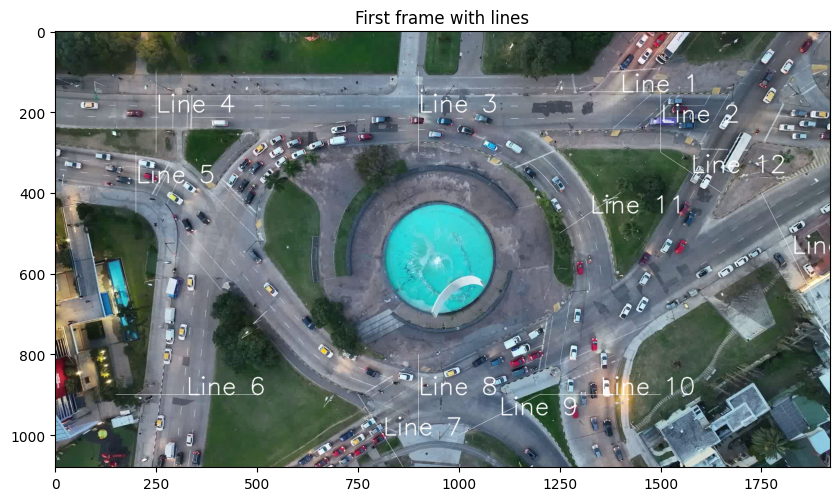

Confirm drawn lines (yes/no): yes
Coordinates for Line 1: (1300,150) --> (1500,150)
Coordinates for Line 2: (1500,150) --> (1500,300)
Coordinates for Line 3: (900,100) --> (900,300)
Coordinates for Line 4: (250,100) --> (250,300)
Coordinates for Line 5: (200,300) --> (200,450)
Coordinates for Line 6: (150,900) --> (500,900)
Coordinates for Line 7: (750,900) --> (875,1100)
Coordinates for Line 8: (900,800) --> (900,1000)
Coordinates for Line 9: (1000,1000) --> (1200,900)
Coordinates for Line 10: (1200,900) --> (1500,900)
Coordinates for Line 11: (1250,500) --> (1400,400)
Coordinates for Line 12: (1500,300) --> (1650,400)
Coordinates for Line 13: (1750,400) --> (1900,700)
Enter the line numbers for each trajectory in the format n n n n (one line per trajectory). Type 'done' when finished.
Enter line numbers for Trajectory t1: 1 6
Enter line numbers for Trajectory t2: 2 6
Enter line numbers for Trajectory t3: 2 4
Enter line numbers for Trajectory t4: 1 8 9
Enter line numbers for Trajector

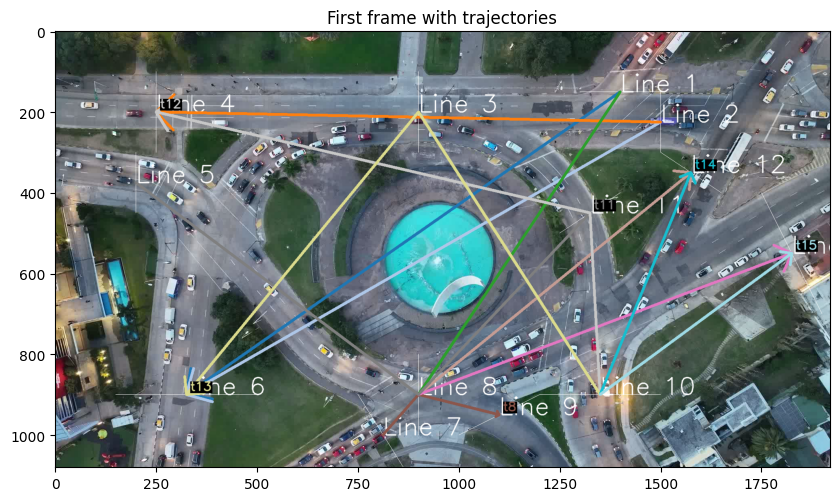

Reassigning lost IDs: 100%|██████████| 6854/6854 [01:33<00:00, 73.65it/s]


511 lost IDs were reassigned


Creating video: 100%|██████████| 6854/6854 [11:27<00:00,  9.97it/s]



Tracked video saved to /content/drive/MyDrive/CSI/RESIZED_DJI_20240604175037_0009_V_tracking_thresh_09.mp4

------------------------------ Trajectory t1 ------------------------------
Lines: [1, 6]   |   Total counted vehicles:  25   |   Counted vehicles IDs:  [769, 775, 32, 801, 37, 302, 306, 818, 317, 829, 833, 332, 850, 856, 357, 744, 361, 876, 241, 242, 759, 888, 252, 893, 766]

------------------------------ Trajectory t2 ------------------------------
Lines: [2, 6]   |   Total counted vehicles:  21   |   Counted vehicles IDs:  [1041, 407, 925, 426, 944, 50, 53, 54, 437, 949, 441, 446, 959, 962, 454, 456, 975, 472, 1002, 1010, 500]

------------------------------ Trajectory t3 ------------------------------
Lines: [2, 4]   |   Total counted vehicles:  30   |   Counted vehicles IDs:  [513, 386, 1025, 1030, 648, 1033, 409, 420, 36, 41, 42, 428, 46, 48, 574, 448, 195, 464, 466, 467, 470, 982, 477, 478, 992, 609, 484, 872, 1001, 623]

------------------------------ Trajectory t4 ----

In [10]:
# TRACKING EN VIDEOS
#video_path = '/content/drive/MyDrive/Conteo de Maniobras/DJI_20240604174215_0006_V.mp4' # video corto desde arriba
#video_path = '/content/drive/MyDrive/Conteo de Maniobras/RESIZED_DJI_20240604174215_0006_V.mp4' # video corto desde arriba RESIZED
#video_path = '/content/drive/MyDrive/Conteo de Maniobras/DJI_20240604175037_0009_V.mp4' # video largo desde arriba
#video_path = '/content/drive/MyDrive/Conteo de Maniobras/RESIZED_DJI_20240604175037_0009_V.mp4' # video largo desde arriba RESIZED
#video_path = '/content/drive/MyDrive/Conteo de Maniobras/RESIZED_DJI_20240604175037_0009_V_cropped.mp4' # video largo desde arriba RESIZED y CROPPED
#video_path = '/content/drive/MyDrive/CSI/RESIZED_DJI_20240604175037_0009_V.mp4' # video largo desde arriba
#video_path = '/content/drive/MyDrive/Conteo de Maniobras/Videos Viejos/DJI_0002.mp4' # video viejo desde un ángulo
#video_path = '/content/drive/MyDrive/Conteo de Maniobras/RESIZED_DJI_20241003123313_0001_V.mp4' # video nuevo 0001
#video_path = '/content/drive/MyDrive/CSI/RESIZED_DJI_20241003123313_0001_V_cropped.mp4' # video nuevo 0001 PERSONAL CROPPED
#video_path = '/content/drive/MyDrive/CSI/RESIZED_DJI_20241003123313_0001_V.mp4' # video nuevo 0001 PERSONAL
video_path = '/content/drive/MyDrive/CSI/RESIZED_DJI_20240604175037_0009_V.mp4' # video viejo 0009 PERSONAL

#output_folder = '/content/drive/MyDrive/Conteo de Maniobras/Models/FasterRCNN/re_train/Test/Reassigning_IDs/'
output_folder = '/content/drive/MyDrive/CSI/'
output_video_path = output_folder+video_path.split('/')[-1].replace('.mp4', '_tracking_thresh_09.mp4')

lines_points_0001 = [
    (500, 200, 500, 500),  # Line 1
    (950, 100, 950, 400),  # Line 2
    (1400, 200, 1400, 500),  # Line 3
    (500, 500, 500, 700),  # Line 4
    (950, 600, 950, 900),  # Line 5
    (1400, 500, 1400, 700),  # Line 6
    (750, 850, 900, 850),  # Line 7
    (900, 850, 1100, 850)  # Line 8
]

trajectories_0001 = [
    [4, 7],      # Trajectory t1
    [4, 5, 6],   # Trajectory t2
    [8, 6],      # Trajectory t3
    [8, 2, 1],   # Trajectory t4
    [3, 2, 1],   # Trajectory t5
    [3, 2, 7]    # Trajectory t6
]

lines_points_0009 = [
    (1300, 150, 1500, 150),  # Line 1
    (1500, 150, 1500, 300),  # Line 2
    (900, 100, 900, 300),    # Line 3
    (250, 100, 250, 300),    # Line 4
    (200, 300, 200, 450),    # Line 5
    (150, 900, 500, 900),    # Line 6
    (750, 900, 875, 1100),   # Line 7
    (900, 800, 900, 1000),   # Line 8
    (1000, 1000, 1200, 900), # Line 9
    (1200, 900, 1500, 900),  # Line 10
    (1250, 500, 1400, 400),  # Line 11
    (1500, 300, 1650, 400),  # Line 12
    (1750, 400, 1900, 700)   # Line 13
]

trajectories_0009 = [
    [1, 6],         # Trajectory t1
    [2, 6],         # Trajectory t2
    [2, 4],         # Trajectory t3
    [1, 8, 9],      # Trajectory t4
    [7, 8, 12],     # Trajectory t5
    [7, 8, 13],     # Trajectory t6
    [7, 8, 11],     # Trajectory t7
    [7, 8, 9],      # Trajectory t8
    [5, 8, 12],     # Trajectory t9
    [5, 8, 13],     # Trajectory t10
    [5, 8, 11],     # Trajectory t11
    [10, 11, 4],    # Trajectory t12
    [10, 3, 6],     # Trajectory t13
    [10, 12],       # Trajectory t14
    [10, 13]        # Trajectory t15
]



# ByteTrack
tracks,df = predict_and_track_on_video(video_path=video_path, output_video_path=output_video_path, predictor=predictor, bbox_tracked='color',
                               bbox_untracked='box', annotate_untracked=True, slice_frames=True, classes=class_names, overlap_wh=(0.2, 0.2), slice_wh=(512,512),
                               frame_step=1, json_dump=True, tracker_alg='ByteTrack', reassign_ids=True)

In [11]:
path = '/content/drive/MyDrive/CSI/df_0009_09thresh.csv'
df.to_csv(path, index=False)

In [ ]:
filled_detections[0].class_id

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
for tracker_id, group in tqdm(tracks.groupby('tracker_id'), desc='Interpolating detections between frames',):
    group = group.sort_values('frame')
    frames = group['frame'].values
    bboxes = group[['x_min', 'y_min', 'x_max', 'y_max']].values
    class_ids = group['class_id'].values
    print(group[group['frame'] == 0]['class_id'].values[0])
    print(type(group[group['frame'] == 0]['class_id'].values[0]))
    #print(group)

    break

Interpolating detections between frames:   0%|          | 0/205 [00:00<?, ?it/s]

0
<class 'numpy.int64'>


In [ ]:
tracks

frame  tracker_id        x_min        y_min        x_max        y_max
0        0           1   217.878937   349.752808   258.103821   373.828125
1        0           2   313.052948   461.134827   343.034363   498.796722
2        0           3   313.970367   370.474487   352.372986   401.937927
3        0           4   205.798569   315.538300   251.193726   341.756134
4        0           5   123.110977   330.749146   166.513153   352.305695
..     ...         ...          ...          ...          ...          ...
108      0         109  1587.519259   577.856870  1631.335066   612.762563
109      0         110  1779.944159   547.051453  1810.218024   581.722295
110      0         111   298.778564  1043.989118   319.134827  1074.889951
111      0         112  1161.154291  1032.497410  1191.489999  1062.497484
112      0         113  1381.363702  1026.006576  1408.487573  1065.854299

[113 rows x 6 columns]

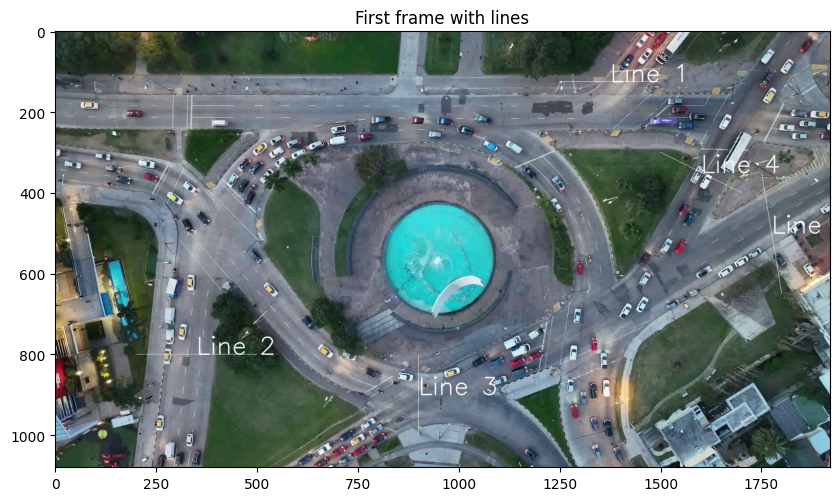

Using provided line points:
Coordinates for Line 1: (1250,125) --> (1500,125)
Coordinates for Line 2: (200,800) --> (500,800)
Coordinates for Line 3: (900,800) --> (900,1000)
Coordinates for Line 4: (1500,300) --> (1700,400)
Coordinates for Line 5: (1750,350) --> (1800,650)

Using provided trajectories:
Lines for Trajectory t1: [1]
Lines for Trajectory t2: [1, 2]
Lines for Trajectory t3: [3]
Lines for Trajectory t4: [3, 4]
Lines for Trajectory t5: [3, 5]


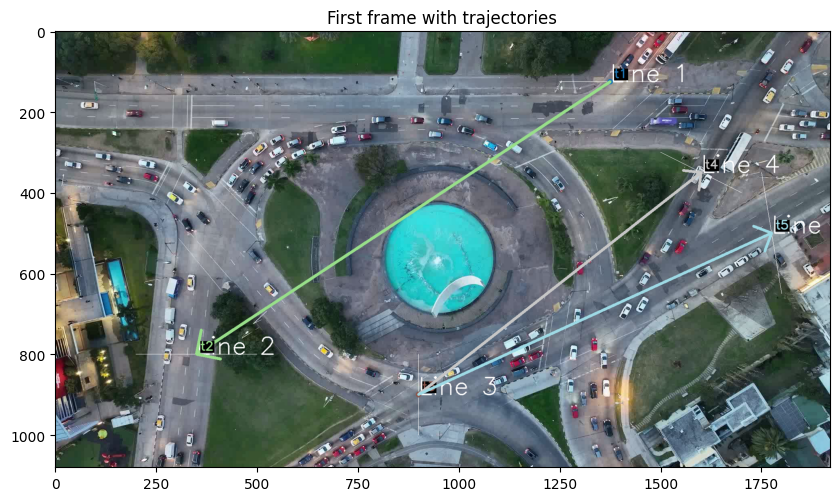

Processing frames: 100%|██████████| 1740/1740 [49:19<00:00,  1.70s/it]


Tracked video saved to /content/drive/MyDrive/Conteo de Maniobras/Models/FasterRCNN/re_train/Test/RESIZED_DJI_20240604175037_0009_V_cropped_tracking_DeepSort_BASE.mp4

------------------------------ Trajectory t1 ------------------------------
Lines: [1]   |   Total counted vehicles:  25   |   Counted vehicles IDs:  [6, 141, 15, 18, 19, 22, 23, 26, 38, 41, 47, 305, 49, 51, 186, 190, 64, 327, 79, 102, 230, 103, 125, 123, 253]

------------------------------ Trajectory t2 ------------------------------
Lines: [1, 2]   |   Total counted vehicles:  0   |   Counted vehicles IDs:  []

------------------------------ Trajectory t3 ------------------------------
Lines: [3]   |   Total counted vehicles:  65   |   Counted vehicles IDs:  [384, 386, 387, 388, 255, 262, 137, 394, 11, 9, 13, 397, 273, 401, 277, 150, 280, 281, 26, 282, 283, 284, 35, 292, 294, 300, 46, 175, 181, 58, 191, 321, 322, 323, 325, 332, 79, 335, 82, 340, 213, 342, 343, 88, 216, 222, 253, 356, 122, 104, 360, 106, 363, 241, 369

In [ ]:
# DeepSort
output_video_path = output_folder+video_path.split('/')[-1].replace('.mp4', '_tracking_DeepSort_BASE.mp4')

tracks = predict_and_track_on_video(video_path=video_path, output_video_path=output_video_path, predictor=predictor, bbox_tracked='color',
                               bbox_untracked='box', annotate_untracked=False, slice_frames=True, classes=class_names, overlap_wh=(0.2, 0.2), slice_wh=(512,512),
                               frame_step=1, lines_points=lines_points, trajectories=trajectories, json_dump=True, tracker_alg='DeepSort')

In [ ]:
tracks

{'t1': {'lines': [1],
  'counted_ids': [1026,
   900,
   781,
   1165,
   787,
   1940,
   1941,
   1817,
   924,
   798,
   926,
   1952,
   1826,
   931,
   1570,
   1827,
   38,
   814,
   944,
   49,
   50,
   945,
   1844,
   821,
   54,
   823,
   696,
   56,
   1842,
   1980,
   831,
   704,
   1985,
   836,
   1863,
   840,
   713,
   846,
   974,
   848,
   1873,
   2002,
   1107,
   2000,
   725,
   2010,
   859,
   735,
   2015,
   867,
   2021,
   743,
   871,
   1898,
   2032,
   888,
   764,
   1918]},
 't2': {'lines': [2],
  'counted_ids': [2434,
   1539,
   1542,
   1671,
   519,
   647,
   140,
   2700,
   527,
   1424,
   1681,
   2577,
   1683,
   2580,
   2705,
   662,
   1558,
   1560,
   2458,
   410,
   413,
   32,
   545,
   34,
   674,
   1442,
   1569,
   2598,
   39,
   679,
   1448,
   1533,
   2605,
   2606,
   1713,
   1460,
   566,
   1594,
   1723,
   1724,
   2490,
   2494,
   2618,
   1600,
   2629,
   1609,
   586,
   1482,
   590,
   2510,
   2638,
 

In [ ]:


# Use the custom encoder
json.dump(tracks, open('/content/drive/MyDrive/Conteo de Maniobras/Models/FasterRCNN/re_train/Test/tracks.json', 'w'), cls=NumpyEncoder)



In [ ]:
# Read the image
img_path = '/content/drive/MyDrive/Conteo de Maniobras/Models/Datasets/roundabouts/imgs/val/00001_frame000310_original.jpg'
img = cv2.imread(img_path)

# Make predictions
outputs = predictor(img)    # Read the image
detections = sv.Detections.from_detectron2(outputs)
tracker = sv.ByteTrack()
tracker.reset()
detections = tracker.update_with_detections(detections)
detections

Detections(xyxy=array([[8.07007690e+02, 3.02799473e+01, 8.71024231e+02, 8.58013000e+01],
       [7.07641754e+01, 2.00146576e+02, 1.16047646e+02, 2.63041901e+02],
       [2.66536438e+02, 2.15341339e+02, 3.05546417e+02, 2.85439117e+02],
       [6.41987610e+02, 1.25526222e+02, 6.92820374e+02, 1.95290955e+02],
       [7.08304199e+02, 8.81375885e+01, 7.72939819e+02, 1.49347122e+02],
       [3.62395592e+01, 1.96444717e+02, 7.34890976e+01, 2.58328979e+02],
       [7.37189514e+02, 6.02901573e+01, 7.97685730e+02, 1.20567993e+02],
       [5.59974731e+02, 1.63582153e+02, 6.02438232e+02, 2.18156357e+02],
       [4.13743744e+02, 2.15317322e+02, 4.47559418e+02, 2.75700562e+02],
       [3.04690704e+02, 2.17895874e+02, 3.40732819e+02, 2.81066864e+02],
       [6.05095154e+02, 1.39963821e+02, 6.55306519e+02, 2.06189438e+02],
       [2.25561752e+02, 2.03429642e+02, 2.61998138e+02, 2.74965179e+02],
       [3.42792786e+02, 2.19030472e+02, 3.73730804e+02, 2.77750214e+02],
       [6.71946777e+02, 1.03509361e

In [ ]:
counted_ids = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
counted_mask = np.isin(detections.tracker_id, counted_ids)
uncounted_mask = ~counted_mask

{key: np.array(value)[counted_mask].tolist() for key, value in detections.data.items()}

{}

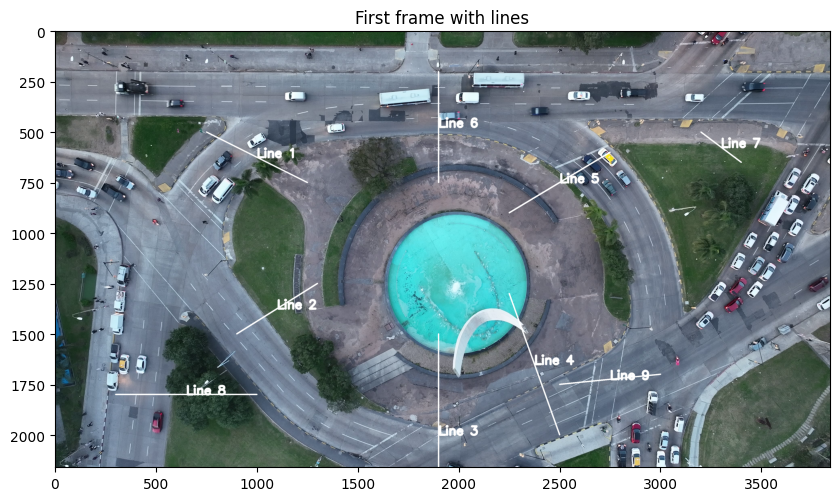

Confirm drawn lines (yes/no): yes
Line Points: [(750, 500, 1250, 750), (900, 1500, 1300, 1250), (1900, 1500, 1900, 2500), (2250, 1300, 2500, 2000), (2250, 900, 2750, 600), (1900, 200, 1900, 750), (3200, 500, 3400, 650), (300, 1800, 1000, 1800), (2500, 1750, 3000, 1700)]


[(750, 500, 1250, 750),
 (900, 1500, 1300, 1250),
 (1900, 1500, 1900, 2500),
 (2250, 1300, 2500, 2000),
 (2250, 900, 2750, 600),
 (1900, 200, 1900, 750),
 (3200, 500, 3400, 650),
 (300, 1800, 1000, 1800),
 (2500, 1750, 3000, 1700)]

In [ ]:
video_path = '/content/drive/MyDrive/Conteo de Maniobras/DJI_20240604174215_0006_V.mp4' # video corto desde arriba
draw_lines_on_video(video_path)

In [ ]:
# @title **FUNCIÓN PARA DIBUJAR LÍNEAS A MANO. NO ANDA EN COLAB**
#
# Global variables to store line points
line_points = []
drawing = False
current_point = ()

def draw_line(event, x, y, flags, param):
    global line_points, drawing, current_point

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        current_point = (x, y)

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            img_copy = param[0].copy()
            cv2.line(img_copy, current_point, (x, y), (0, 255, 0), 2)
            # Update the frame in the parameter
            param[1] = img_copy

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        line_points.append((current_point[0], current_point[1], x, y))
        cv2.line(param[0], current_point, (x, y), (0, 255, 0), 2)
        # Update the frame in the parameter
        param[1] = param[0].copy()

def get_line_points_from_video(video_path):
    global line_points

    # Get the first frame from the video
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    if not ret:
        print("Error: Unable to read video")
        return []

    # Display the frame and set up the callback for drawing lines
    temp_frame = frame.copy()
    cv2_imshow(frame)
    cv2.setMouseCallback("Draw Lines", draw_line, param=[frame, temp_frame])

    print("Draw lines on the frame and press 'q' when done.")

    while True:
        cv2_imshow(temp_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()
    cap.release()

    return line_points
